In [1]:
%matplotlib inline

In [3]:
from statsbombpy import sb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm, rcParams
import os

from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from mplsoccer.utils import FontManager
import seaborn as sns
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
import matplotsoccer as mps

from PIL import Image

from urllib.request import urlopen, urlretrieve
from highlight_text import HighlightText, ax_text, fig_text
import requests
from io import BytesIO
from scipy.spatial  import ConvexHull
from scipy import stats
from highlight_text import htext


print("Done :)")

Done :)


In [4]:
pd.options.display.max_columns = 500

In [5]:
df = sb.events(match_id=3835329)

In [6]:
im = Image.open(r"C:\Users\Gusse\OneDrive\Dokumenter\Python\Womens Euro 2022\sb_text_logo.png")

In [7]:
allshots = pd.read_csv("allshots.csv")
allshots = allshots[['minute',"second",  'team', 'shot_statsbomb_xg', 'player', 'shot_outcome',]]
allshots = allshots.sort_values(by =['minute', 'second'], ascending = [True, True])
allshots = allshots.reset_index(drop=True)

In [8]:
allgoals = pd.read_csv("goals.csv")

In [9]:
pitchColor = "#7FB069"
figColor = "#7FB069"
linesColor = "black"
hteamColor = "#E32219"
ateamColor = "#003581"
MVP = 10108
MVPname = "Pernille Harder"
tournament = "Women's EURO 2022"
textColor = "black"
hteam = "Denmark Women's"
ateam = "WNT Finland"
pitchCmap = LinearSegmentedColormap.from_list("pitch heatmap", ["#7FB069",hteamColor], N=100)

In [10]:
dfFin = df[df["team"] == ateam]
dfDen = df[df["team"] == hteam]

In [11]:
lineupDK = sb.lineups(match_id=3835329)[hteam]
lineupDK = lineupDK.drop("cards", axis=1)
lineupDK = lineupDK.drop("country", axis=1)
lineupDK = lineupDK.drop("positions", axis=1)
lineupDK = lineupDK.rename(columns={'player_id': 'passer'})
lineupDK = lineupDK.sort_values("jersey_number", ascending=True)

In [12]:
shots = df[df.type == "Shot"]
shots = shots[shots.team == hteam]

shots = shots[['team', 'player', 'minute', 'second', 'location',"shot_end_location", 'shot_statsbomb_xg', 'shot_outcome', "type", "id", "shot_key_pass_id"]]

shots['x'] = shots.location.apply(lambda x: x[0])
shots['y'] = shots.location.apply(lambda x: x[1])
shots = shots.drop('location', axis=1)


shots_fin = df[df.type == "Shot"]
shots_fin = shots_fin[shots_fin.team == ateam]

shots_fin = shots_fin[['team', 'player', 'minute', 'second', 'location',"shot_end_location", 'shot_statsbomb_xg', 'shot_outcome', "type"]]

shots_fin['x'] = shots_fin.location.apply(lambda x: x[0])
shots_fin['y'] = shots_fin.location.apply(lambda x: x[1])
shots_fin = shots_fin.drop('location', axis=1)

goals_fin = shots_fin[shots_fin.shot_outcome == 'Goal']
shots_fin = shots_fin[shots_fin.shot_outcome != 'Goal']
goals = shots[shots.shot_outcome == 'Goal']
shots = shots[shots.shot_outcome != 'Goal']

goals["player"] = goals["player"].apply(lambda x: str(x).split()[-1])
goals_fin["player"] = goals_fin["player"].apply(lambda x: str(x).split()[-1])

In [13]:
ascore = (goals_fin["shot_outcome"]=='Goal').sum()
hscore = (goals["shot_outcome"]=='Goal').sum()

In [14]:
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]
h_min_goals = []
a_min_goals = []
h_goals = []

for i in range(len(allshots['shot_statsbomb_xg'])):
        if allshots['team'][i]==hteam:
            h_xG.append(allshots['shot_statsbomb_xg'][i])
            h_min.append(allshots['minute'][i])
            if allshots['shot_outcome'][i]=='Goal':
                h_min_goals.append(allshots['minute'][i])
        if allshots['team'][i]==ateam:
            a_xG.append(allshots['shot_statsbomb_xg'][i])
            a_min.append(allshots['minute'][i])
            if allshots['shot_outcome'][i]=='Goal':
                a_min_goals.append(allshots['minute'][i])


### Function cumulative add xG values xG. Goes through the list and adds the xG values together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]


 ### Apply defned nums_cumulative_sum function to the home and away xG lists
h_cumulative = nums_cumulative_sum(h_xG)
a_cumulative = nums_cumulative_sum(a_xG)


### Find the total xG. Create a new variable from the last item in the cumulative list
#alast = round(a_cumulative[-1],2)
#hlast = round(h_cumulative[-1],2)
hlast = h_cumulative[-1]
alast = a_cumulative[-1]

### Determine the final cumulative xG (used for the title)
h_final_xg = round(float(hlast), 2)
a_final_xg = round(float(alast), 2)

### Determine the last minute
last_min = max(df['minute'])


### Append last minute to list
h_min.append(last_min)
a_min.append(last_min)


### Append last (final) xG to 
h_cumulative.append(hlast)
a_cumulative.append(alast)


### Determine the maximum xG (used to determine the height of the y-axis)
xg_max = max(alast, hlast)


### Create lists of the time and cumulative xG at the time Away goals were scored

#### Empty list for the indexes of Away goals
a_goals_indexes = []

#### Create list of the indexes for Away goals
for i in range(len(a_min)):
    if a_min[i] in a_min_goals:
        a_goals_indexes.append(i)

#### Empty list for the cumulative xG at the moment Away goals are scored
a_cumulative_goals = []
    
#### Create list of the cumulative xG at the moment Away goals are scored
for i in a_goals_indexes:
    a_cumulative_goals.append(a_cumulative[i])


### Create lists of the time and cumulative xG at the time Home goals were scored
 #### Empty list for the indexes of Home goals
h_goals_indexes = []

    #### Create list of the indexes for Home goals
for i in range(len(h_min)):
    if h_min[i] in h_min_goals:
        h_goals_indexes.append(i)

#### Empty list for the cumulative xG at the moment Home goals are scored
h_cumulative_goals = []

#### Create list of the cumulative xG at the moment Home goals are scored
for i in h_goals_indexes:
    h_cumulative_goals.append(h_cumulative[i])
        
        
### Define fonts and colours
title_font = 'Alegreya Sans'
main_font = 'Open Sans'
title_colour = 'black'
text_colour = 'black'
filler = 'grey'
mpl.rcParams['xtick.color'] = text_colour
mpl.rcParams['ytick.color'] = text_colour
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size':15})


### Create figure 
fig, ax = plt.subplots(figsize=(15, 7))
fig.set_facecolor(pitchColor)
ax.patch.set_facecolor(pitchColor)


### Add a grid and set gridlines
ax.grid(linestyle='dotted',
        linewidth=0.25,
        color='#3B3B3B',
            zorder=1
           )

### Remove top and right spines, colour bttom and left
spines = ['top', 'right', 'bottom', 'left']
for s in spines:
    if s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_color(text_colour)
        
plt.xlabel('Minute', color=textColor, fontsize=16)
plt.ylabel('xG', color=textColor, fontsize=16)
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlim([0, last_min+2])
plt.ylim([0, xg_max*1.1])
            
### Plot xG Race Chart - step chart
ax.step(x=h_min, y=h_cumulative, linewidth=5, where='post', color= hteamColor, label= f"{hteam}: {h_final_xg} xG")
ax.step(x=a_min, y=a_cumulative, linewidth=5, where='post', color=ateamColor, label= f"{ateam}: {a_final_xg} xG")


### Plot goals - scatter plot
ax.scatter(x=h_min_goals, y=h_cumulative_goals, s=1200, color=hteamColor, edgecolors="white", marker='*',
           alpha=1, linewidth=0.5, zorder=2)
ax.scatter(x=a_min_goals, y=a_cumulative_goals, s=1200, color=ateamColor, edgecolors="white", marker='*',
           alpha=1, linewidth=0.5, zorder=2)


plt.legend()     # commented out as colours of teams shown in the title

ax3 = fig.add_axes([0.65, -0.002, 0.20, 0.10])
ax3.axis('off')
ax3.imshow(im)


### Add Plot Title
ax.set_title(f"{hteam} {hscore} - {ascore} {ateam}", fontsize=25, color=textColor)

plt.draw()

plt.savefig('viz/xG Flow Chart.png', dpi=300, bbox_inches='tight')

In [15]:
agg_xg = (allshots.groupby(['player', "team"]).agg({'shot_statsbomb_xg':'sum'}).reset_index())
agg_xg = agg_xg.sort_values(by =["shot_statsbomb_xg"], ascending =False)
agg_xg = agg_xg.head(10)
agg_xg = agg_xg.reset_index(drop=True)

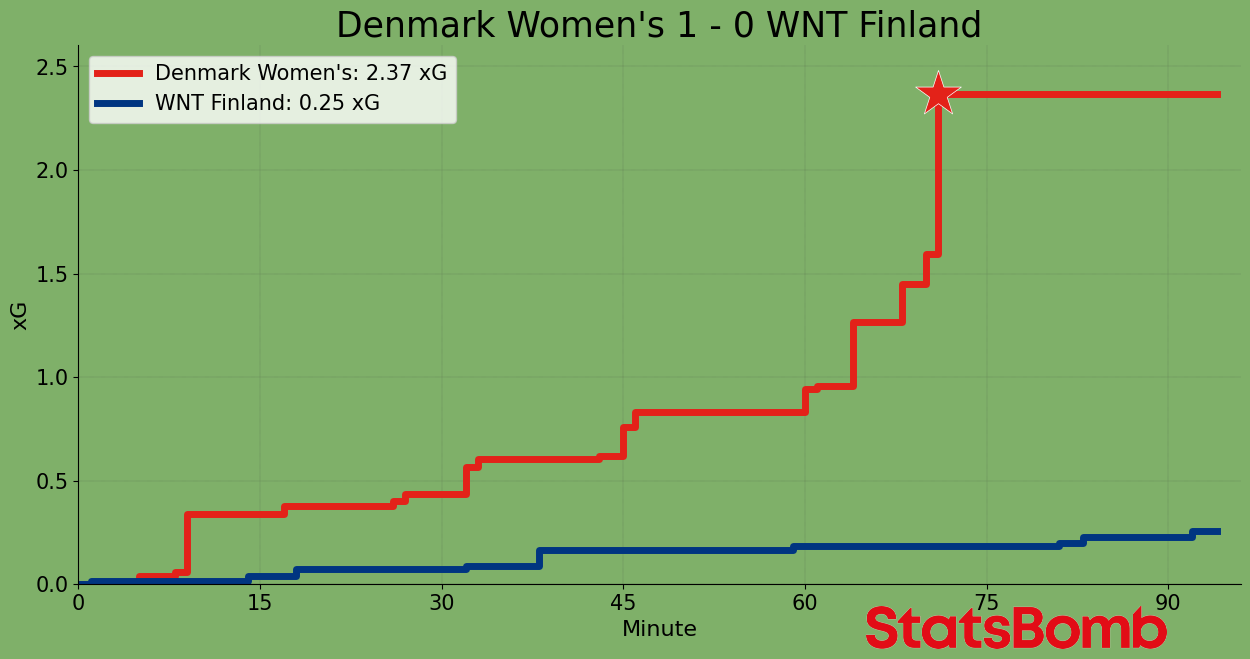

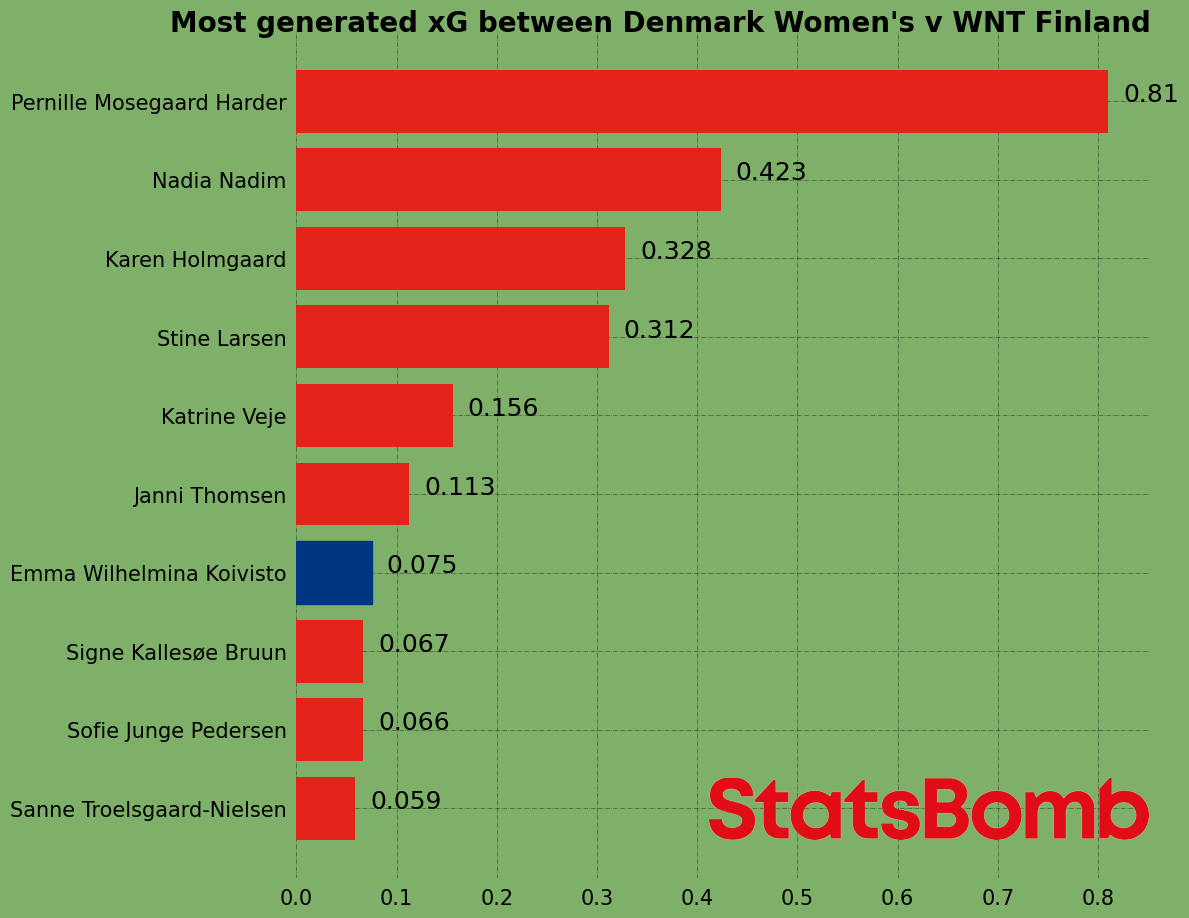

In [16]:
    ### Define labels and metrics
    player = agg_xg['player']
    value = agg_xg['shot_statsbomb_xg']

    ### Create figure 
    fig, ax = plt.subplots(figsize =(11, 11))
    fig.set_facecolor(pitchColor)
    ax.patch.set_facecolor(pitchColor)

    ax.grid(visible=True,
            color='black',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.5,
        zorder=1
           )
    
    
    ### Create Horizontal Bar Plot
    bars = ax.barh(player,
                   value,
                   color=hteamColor,
                   alpha=1,
                   zorder=2
                  )

    
selected_player_1=6 
selected_player_1_colour=ateamColor
bars[selected_player_1].set_color(selected_player_1_colour)

spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.invert_yaxis()




for i in ax.patches:
        plt.text(i.get_width()+0.015, i.get_y()+0.4,
                 str(round((i.get_width()), 3)),
                 fontsize=18,
                 fontweight='regular',
                 color ='black')
        
plt.figtext(0.01,
                0.88,
                f'Most generated xG between {hteam} v {ateam}',
                fontsize=20,
                fontweight='bold', 
                color=textColor
               )    
    
ax3 = fig.add_axes([0.50, -0.002, 0.40, 0.35])
ax3.axis('off')
ax3.imshow(im)


plt.show()

#plt.savefig(f'viz/top 10 xG created, {hteam} vs {ateam}', dpi=300, bbox_inches='tight')

In [17]:
shotsDen = (shots.shape[0]+ goals.shape[0])
shotsFin = shots_fin.shape[0]

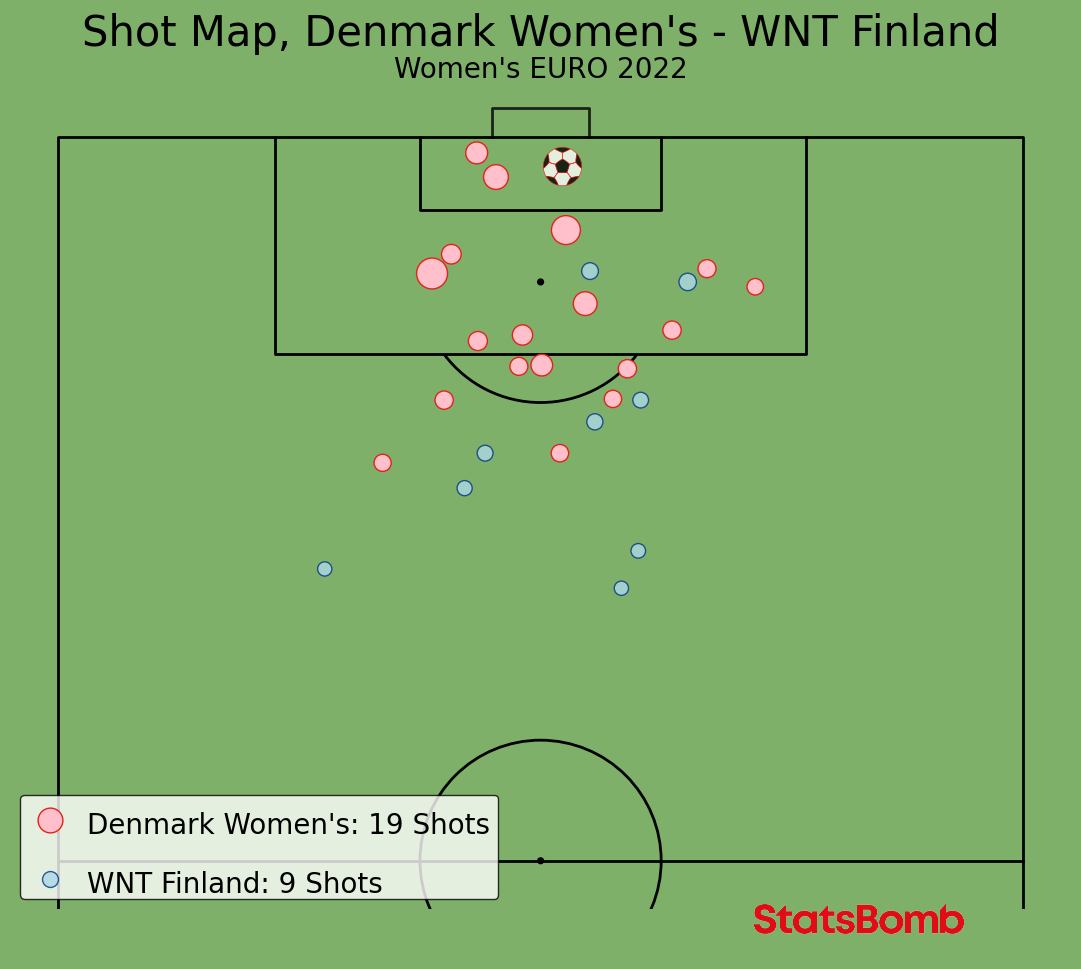

In [38]:
pitch = VerticalPitch(pitch_type='statsbomb', half=True, goal_type="box", goal_alpha=0.8,
                      pitch_color=pitchColor, line_color=linesColor)

fig,axs= pitch.grid(figheight=10, title_height=0.08, endnote_space=0, 
                    axis=False,title_space=0, grid_height=0.82, endnote_height=0.05)

fig.set_facecolor(figColor)

scatter_shots = pitch.scatter(shots.x, shots.y, s=(shots.shot_statsbomb_xg * 900) + 130, 
                              c='pink', edgecolors= hteamColor, marker='o', 
                              alpha = 1, ax=axs['pitch'], label=f"{hteam}: {shotsDen} Shots")

scatter_goals= pitch.scatter(goals.x, goals.y, s=(goals.shot_statsbomb_xg * 900) + 130, 
                             c="white", edgecolor= hteamColor, marker="football", ax=axs["pitch"], 
                             alpha = .80)

scatter_shots_fin = pitch.scatter(shots_fin.x, shots_fin.y, s=(shots_fin.shot_statsbomb_xg * 900) + 100,
                                  c='lightblue', edgecolors=ateamColor, marker='o', 
                                  alpha = .80, label=f"{ateam}: {shotsFin} Shots", ax=axs['pitch'])

HighlightText(x=0.25, y=0.5,
              s='The weather is <sunny>\nYesterday it was <cloudy>',
              highlight_textprops=[{"color": 'yellow'},
                                   {"color": 'grey'}],
              ax=ax)


axs["title"].text (0.5, 0.7, (f"Shot Map, {hteam} - {ateam}"), color=textColor, va="center", ha="center", fontsize=30)


axs["title"].text (0.5, 0.25, tournament, color=textColor, va="center", ha="center", fontsize=20)

legend = axs['pitch'].legend(loc='lower left', facecolor="white", edgecolor="black", labelspacing=1.5)
for text in legend.get_texts():
    text.set_fontsize(20)
    text.set_va('center')
    
ax3 = fig.add_axes([0.65, 0.050, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

plt.show()

#plt.savefig(f'viz/Shot Map, {hteam} v {ateam}', dpi=300, bbox_inches='tight')

In [19]:
match_360_df = pd.read_json(f"C:\\Users\\Gusse\\OneDrive\\Dokumenter\\GitHub\\open-data\\data\\three-sixty\\3835329.json")

In [20]:
df_360= pd.merge(left=dfDen, right=match_360_df, left_on="id", right_on="event_uuid", how="left")

In [21]:
df_360 = df_360[(df_360["player_id"]==MVP) & (df_360["shot_outcome"]== "Goal")].reset_index(drop=True)

In [22]:
df_360['x'] = df_360.location.apply(lambda x: x[0])
df_360['y'] = df_360.location.apply(lambda x: x[1])

In [23]:
df_360['x_end'] = df_360.shot_end_location.apply(lambda x: x[0])
df_360['y_end'] = df_360.shot_end_location.apply(lambda x: x[1])

In [36]:
pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-20)
fig, ax = pitch.draw(figsize=(12,8))

fig.set_facecolor(figColor)

df_360=df_360[0:1]

pitch.scatter(y=df_360["y"], x=df_360["x"], ax=ax)
pitch.lines(xstart=df_360["y"], ystart=df_360["x"], xend=df_360["y_end"], yend=df_360["x_end"],
        ax=ax, color= "pink", comet=True)

for x in df_360.iloc[0]["freeze_frame"]:
    if x["teammate"]:
        color = hteamColor
    else:
        color = ateamColor
    
    
    pitch.scatter(x=x["location"][1], y=x["location"][0], ax=ax, c=color, s=100)

    
ax.set_title(f"{MVPname}s Goal Against {ateam}", fontsize=22, color=textColor)

ax3 = fig.add_axes([0.55, 0.014, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

# plt.draw()    
 
#plt.savefig(f'viz/{MVPname}s Goal Against {ateam}', dpi=300, bbox_inches='tight')

In [31]:
parser = Sbopen()
frames, visible = parser.frame(3835329)

In [212]:
frame_idx = 0
frame_id = visible.iloc[0].id

visible_area = np.array(visible.iloc[frame_idx].visible_area).reshape(-1, 2)
player_position_data = frames[frames.id == frame_id]

teammate_locs = player_position_data[player_position_data.teammate]
opponent_locs = player_position_data[~player_position_data.teammate]

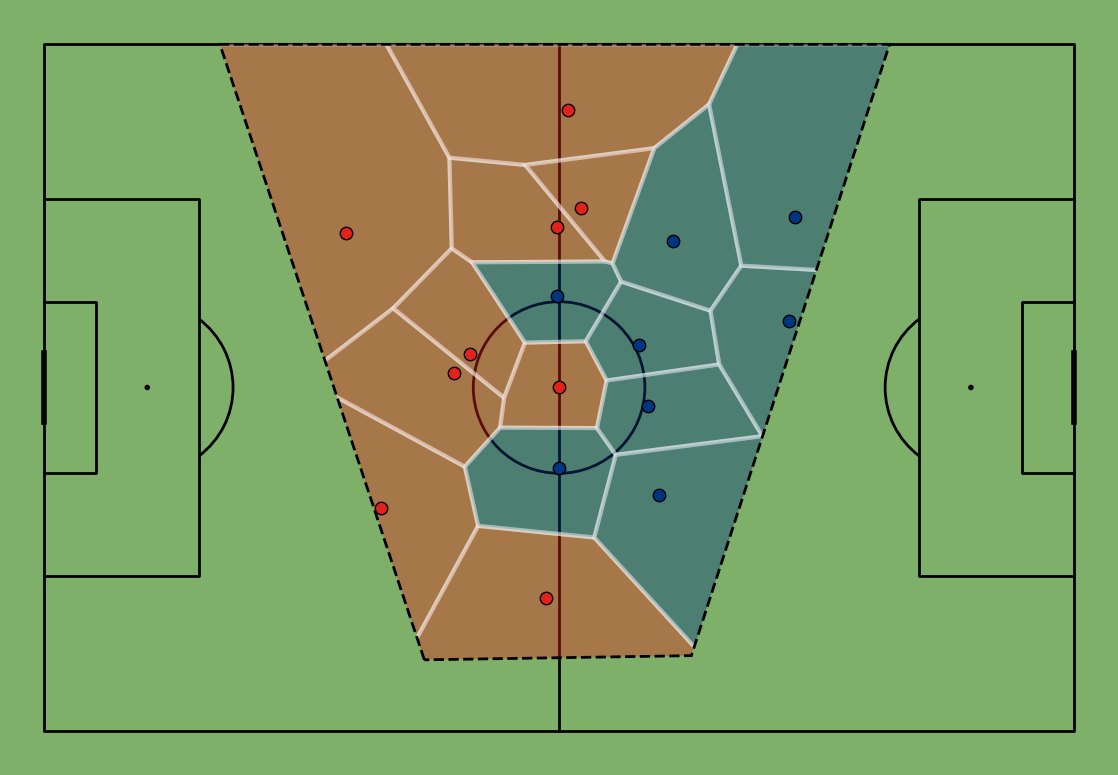

In [213]:
p = Pitch(pitch_type='statsbomb', pitch_color=pitchColor, line_color=linesColor)
fig, ax = p.draw(figsize=(12,8))
fig.set_facecolor(figColor)


# Plot Voronoi
team1, team2 = p.voronoi(player_position_data.x, player_position_data.y,
                         player_position_data.teammate)
t1 = p.polygon(team1, ax=ax, fc=hteamColor, ec='white', lw=3, alpha=0.4)
t2 = p.polygon(team2, ax=ax, fc=ateamColor, ec='white', lw=3, alpha=0.4)

# Plot players
sc1 = p.scatter(teammate_locs.x, teammate_locs.y, c=hteamColor, s=80, ec='k', ax=ax)
sc2 = p.scatter(opponent_locs.x, opponent_locs.y, c=ateamColor, s=80, ec='k', ax=ax)

# Plot the visible area
visible = p.polygon([visible_area], color='None', ec='k', linestyle='--', lw=2, ax=ax)

# clip each player to the visible area
for p1 in t1:
    p1.set_clip_path(visible[0])
for p2 in t2:
    p2.set_clip_path(visible[0])


In [76]:
pass_den = df[df.type == "Pass"]
pass_den = pass_den[pass_den.team == hteam]
pass_den = pass_den[(pass_den["pass_type"]!="Kick Off") & (pass_den["pass_type"]!="Goal Kick") 
                    & (pass_den["pass_type"]!="Free Kick") & (pass_den["pass_type"]!="Throw-in") 
                    & (pass_den["pass_type"]!="Corner") & (pass_den["pass_outcome"]!="Incomplete") 
                    & (pass_den["pass_outcome"]!="Pass Offisde") & (pass_den["pass_outcome"]!="Out") 
                    & (pass_den["pass_outcome"]!="Unknown")]

pass_den = pass_den[['team', 'player', "player_id", 'minute', 'second', 'location', "pass_type", "pass_outcome",
                     "pass_end_location", "type", "pass_assisted_shot_id"]]

pass_den['x_start'] = pass_den.location.apply(lambda x: x[0])
pass_den['y_start'] = pass_den.location.apply(lambda x: x[1])

pass_den['x_end'] = pass_den.pass_end_location.apply(lambda x: x[0])
pass_den['y_end'] = pass_den.pass_end_location.apply(lambda x: x[1])
pass_den = pass_den.drop('location', axis=1)
pass_den = pass_den.drop('pass_end_location', axis=1)
pass_den = pass_den.reset_index()
countPassDen = pass_den.shape[0]

In [77]:
pass_den['beginning'] = np.sqrt(np.square(120-pass_den['x_start']) + np.square(40 -pass_den['y_start']))
pass_den['end'] = np.sqrt(np.square(120 - pass_den['x_end']) + np.square(40 - pass_den['y_end']))

pass_den['progressive'] = [(pass_den['end'][x]) / (pass_den['beginning'][x]) < .75 for x in range(len(pass_den.beginning))]

In [78]:
progPasses_den = pass_den[pass_den["progressive"]==True]

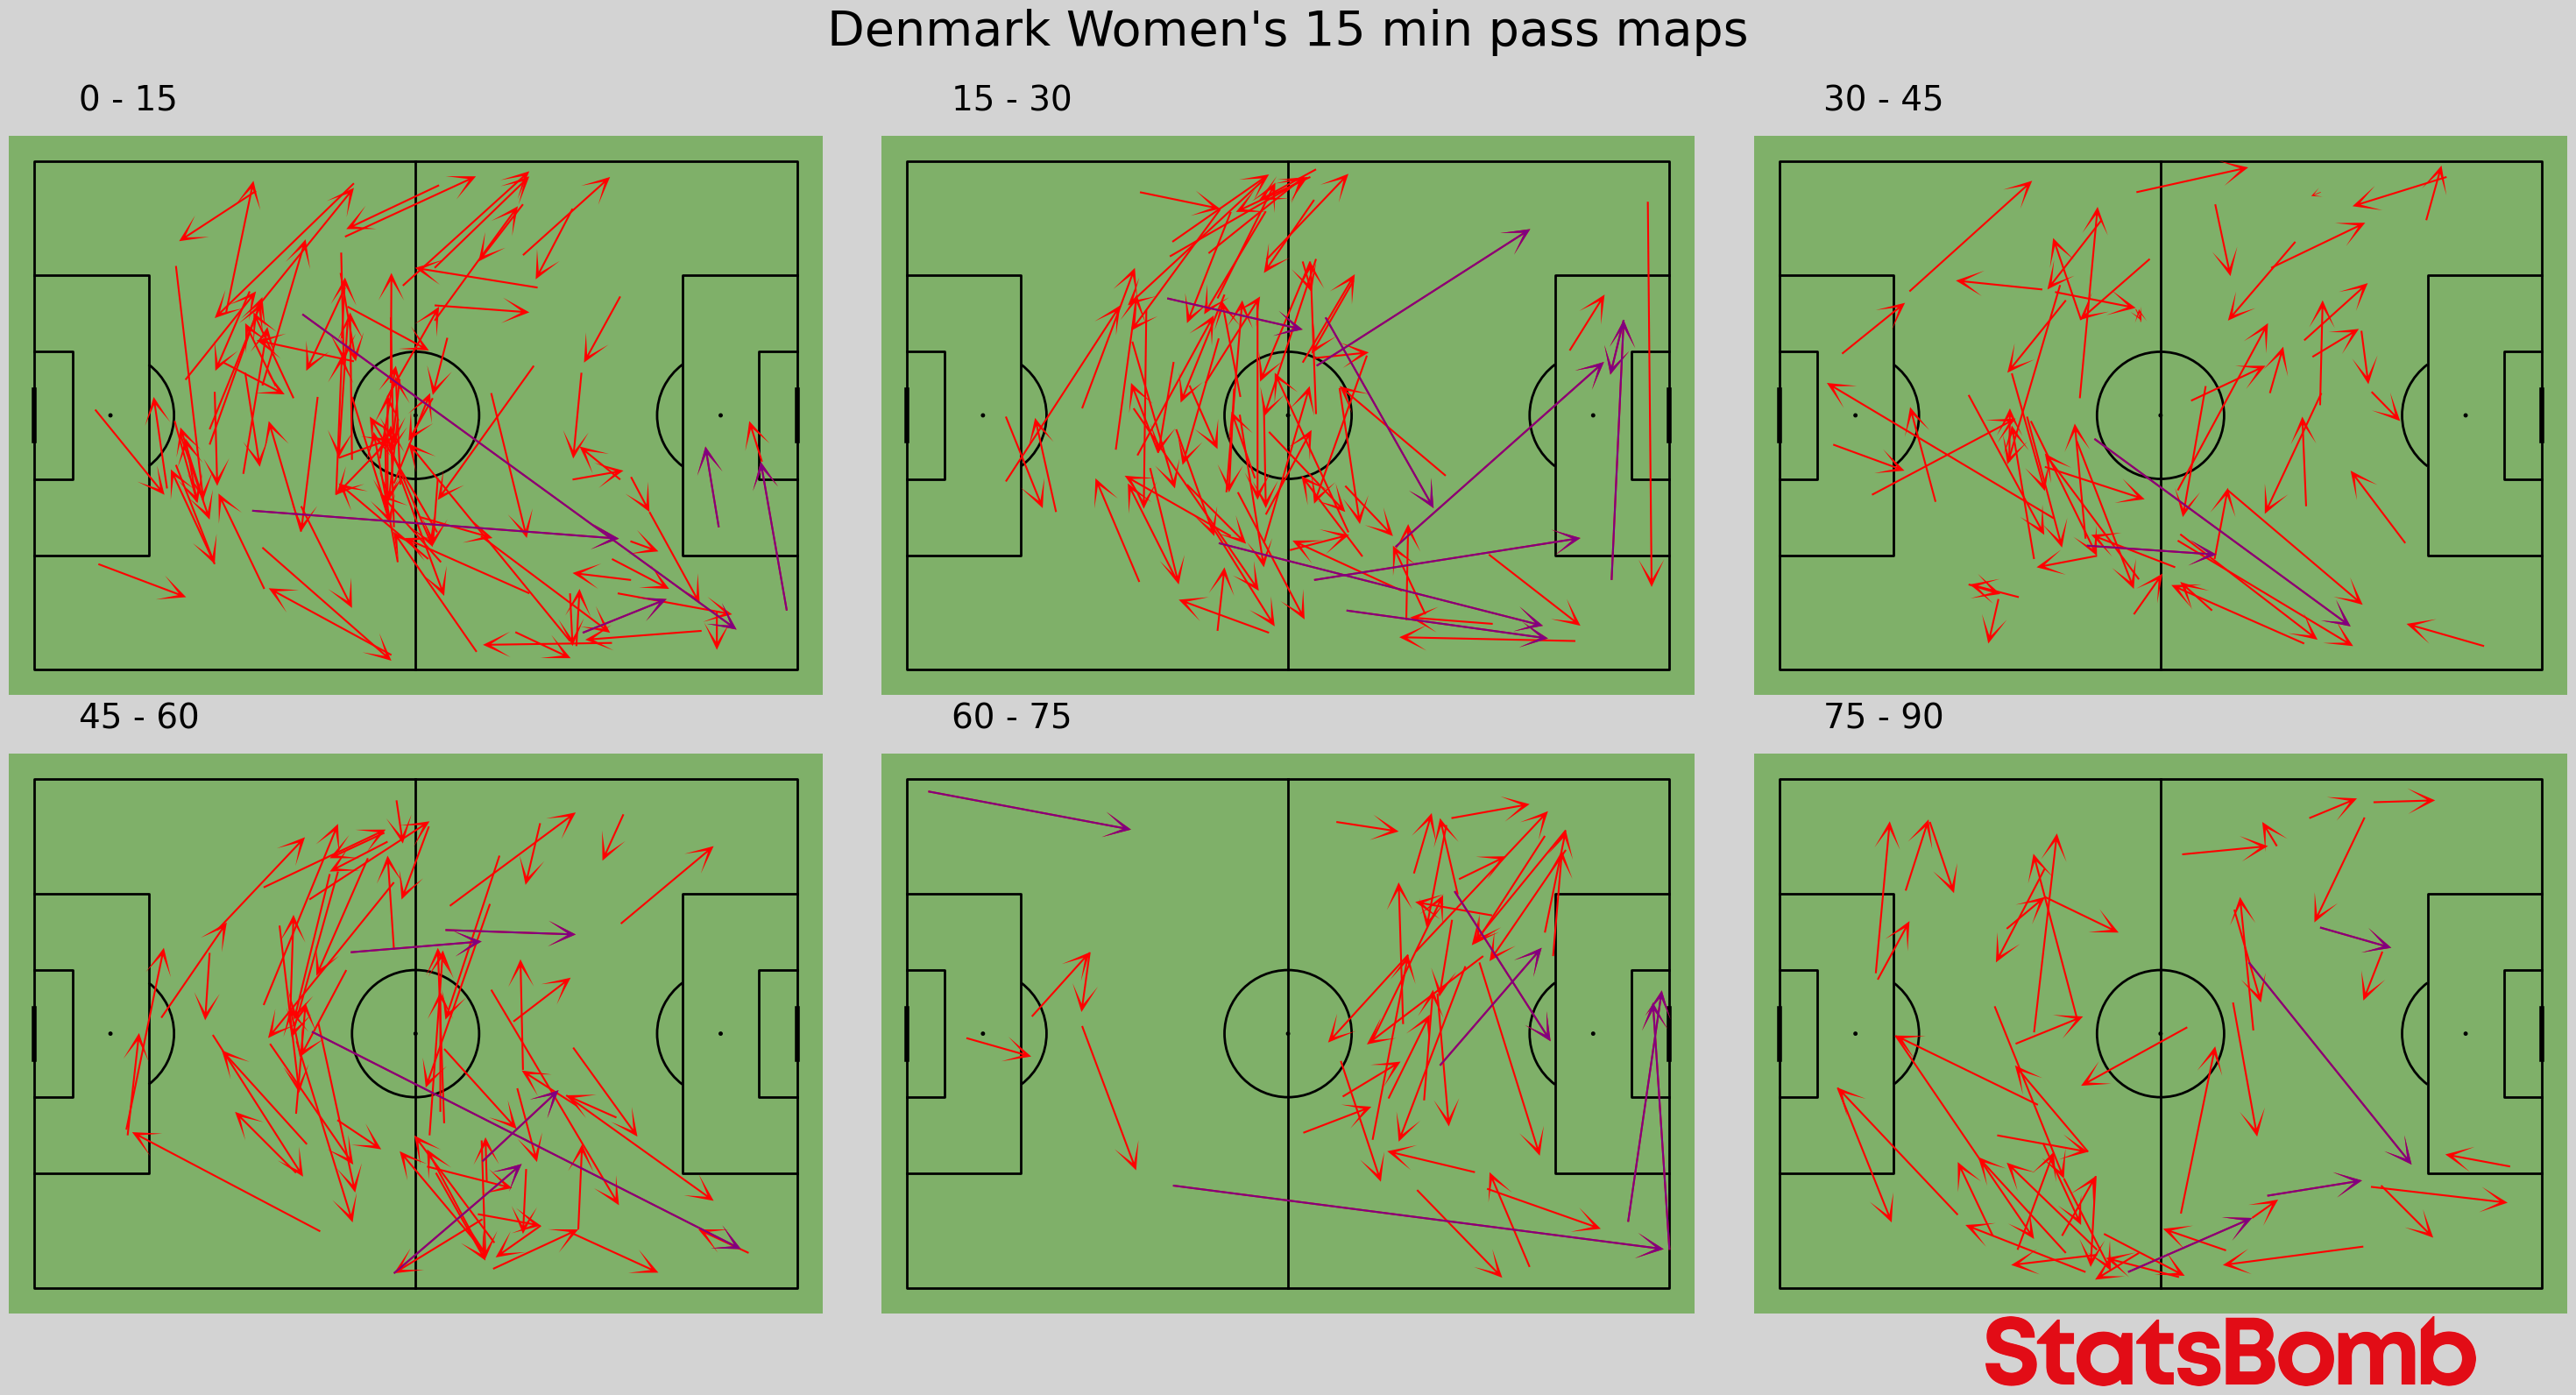

In [79]:
pitch = Pitch(pitch_type="statsbomb", pitch_color=pitchColor, line_color=linesColor)
fig, axs = pitch.grid(ncols=3, nrows=2, endnote_height=0.03, endnote_space=0, axis=False, title_height=0.08, grid_height=0.84, figheight=16)
fig.set_facecolor("lightgrey")

for i, ax in enumerate(axs["pitch"].flat):
    tempPasses = pass_den[(pass_den["minute"]>i*15) & (pass_den["minute"]<i*15+15)]
    tempProg = progPasses_den[(progPasses_den["minute"]>i*15) & (progPasses_den["minute"]<i*15+15)]
    
    
    pitch.arrows(tempPasses["x_start"], tempPasses["y_start"],tempPasses["x_end"], tempPasses["y_end"],
                 ax=ax, width=1.5, headwidth=14, headlength=15, color="red", alpha=1)
    pitch.arrows(tempProg["x_start"], tempProg["y_start"],tempProg["x_end"], tempProg["y_end"], 
                 ax=ax, width=1.5, headwidth=14, headlength=15, color="purple", alpha=1)
    
    ax.text(7, -8, f"{i*15} - {i*15+15}", fontsize=28)
    
axs['title'].text(0.5,0.8,f"{hteam} 15 min pass maps", fontsize=40, ha='center', va='center')

ax3 = fig.add_axes([0.75, -0.002, 0.20, 0.05])
ax3.axis('off')
ax3.imshow(im)

#plt.show()

#plt.savefig(f'viz/Passmap: per min, {hteam} v {ateam}', dpi=300, bbox_inches='tight')

In [80]:
passHarder = df[df["player_id"]== MVP]
passHarder = passHarder[(passHarder["type"]== "Pass") & (passHarder["pass_outcome"]!="Incomplete") 
                        & (passHarder["pass_outcome"]!="Out")]
passHarder = passHarder[['team', 'player', "player_id", 'minute', 'second', 'location', "pass_type", "pass_outcome",
                         "pass_end_location", "type"]]

passHarder['x_start'] = passHarder.location.apply(lambda x: x[0])
passHarder['y_start'] = passHarder.location.apply(lambda x: x[1])

passHarder['x_end'] = passHarder.pass_end_location.apply(lambda x: x[0])
passHarder['y_end'] = passHarder.pass_end_location.apply(lambda x: x[1])
passHarder = passHarder.drop('location', axis=1)
passHarder = passHarder.drop('pass_end_location', axis=1)

countPassHarder = passHarder.shape[0]

In [81]:
passHarder_failed = df[df["player_id"]== MVP]
passHarder_failed = passHarder_failed[passHarder_failed["type"]== "Pass"]
passHarder_failed = passHarder_failed[['team', 'player', "player_id", 'minute', 'second', 'location', "pass_type", 
                                       "pass_outcome",
                         "pass_end_location", "type"]]

passHarder_failed = passHarder_failed[passHarder_failed['pass_outcome'].notna()]

passHarder_failed['x_start'] = passHarder_failed.location.apply(lambda x: x[0])
passHarder_failed['y_start'] = passHarder_failed.location.apply(lambda x: x[1])
passHarder_failed['x_end'] = passHarder_failed.pass_end_location.apply(lambda x: x[0])
passHarder_failed['y_end'] = passHarder_failed.pass_end_location.apply(lambda x: x[1])

countFailedHarder = passHarder_failed.shape[0]

In [82]:
harderProg = progPasses_den[progPasses_den["player_id"]==MVP]

countProgHarder = harderProg.shape[0]

In [83]:
passes = df[(df["type"]== "Pass") & (df["pass_outcome"]!="Incomplete") 
                        & (df["pass_outcome"]!="Out") & (df["pass_outcome"]!="Pass Offside")]
passes = passes[['team', 'player', "player_id", 'minute', 'second', 'location', "pass_type", "pass_outcome",
                         "pass_end_location", "type"]]

passes['x_start'] = passes.location.apply(lambda x: x[0])
passes['y_start'] = passes.location.apply(lambda x: x[1])
passes['x_end'] = passes.pass_end_location.apply(lambda x: x[0])
passes['y_end'] = passes.pass_end_location.apply(lambda x: x[1])


passes = passes.drop("location", axis=1)
passes = passes.drop("pass_end_location", axis=1)

In [84]:
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)

In [85]:
xT_rows, xT_cols = xT.shape

In [86]:
passes["x1_bin"] =pd.cut(passes["x_start"], bins =xT_cols, labels=False)
passes["y1_bin"] =pd.cut(passes["y_start"], bins =xT_rows, labels=False)
passes["x2_bin"] =pd.cut(passes["x_end"], bins =xT_cols, labels=False)
passes["y2_bin"] =pd.cut(passes["y_end"], bins =xT_rows, labels=False)

In [87]:
passes["start_zone_value"] = passes[["x1_bin", "y1_bin"]].apply(lambda x: xT[x[1]][x[0]],axis=1)
passes["end_zone_value"] = passes[["x2_bin", "y2_bin"]].apply(lambda x: xT[x[1]][x[0]],axis=1)

In [88]:
passes["xT"] = passes["end_zone_value"] - passes["start_zone_value"]

In [89]:
agg_xt = (passes.groupby(['player', "team"]).agg({'xT':'sum'}).reset_index())
agg_xt = agg_xt.sort_values(by =["xT"], ascending =False)
agg_xt = agg_xt.head(10)
agg_xt = agg_xt.reset_index(drop=True)

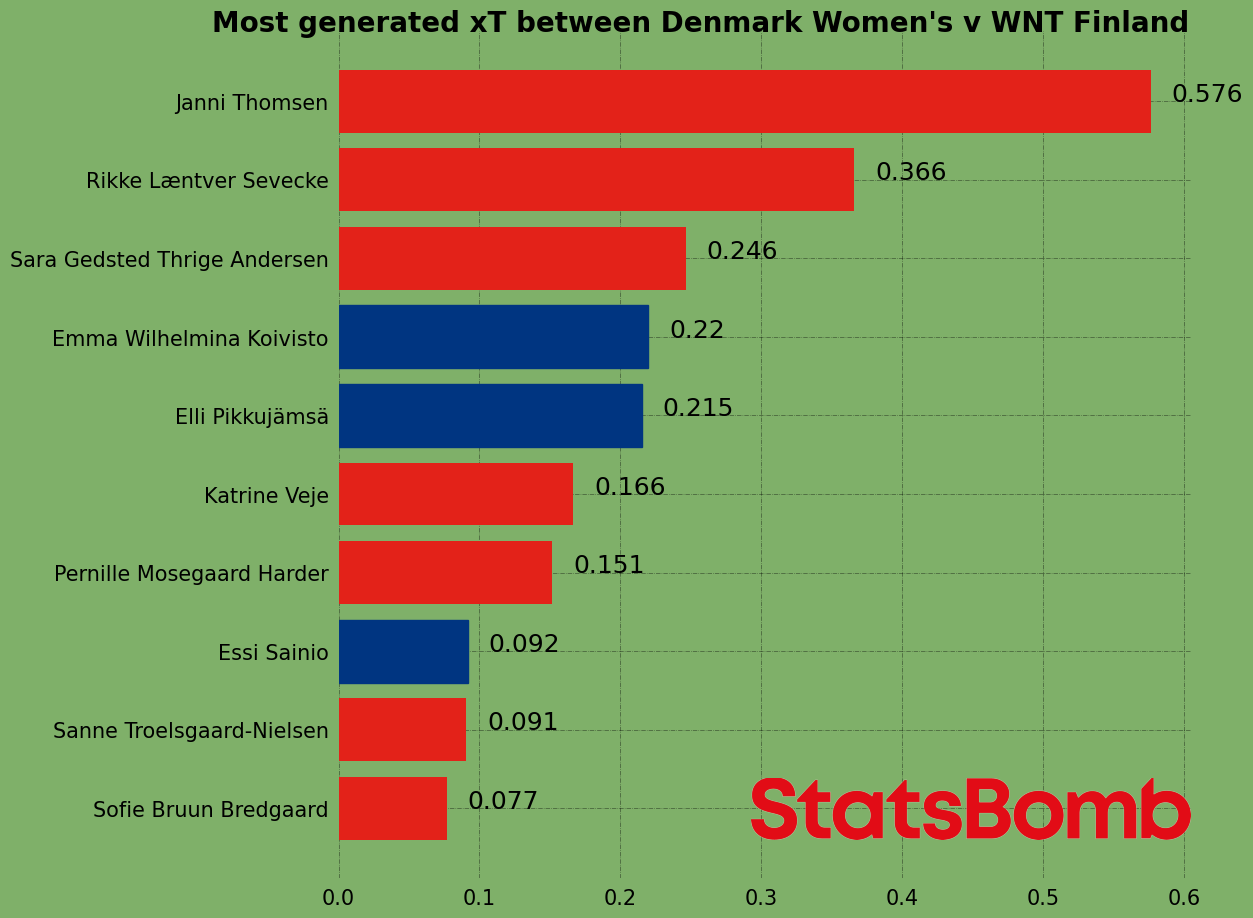

In [90]:
    ### Define labels and metrics
    player = agg_xt['player']
    value = agg_xt['xT']

    ### Create figure 
    fig, ax = plt.subplots(figsize =(11, 11))
    fig.set_facecolor(pitchColor)
    ax.patch.set_facecolor(pitchColor)

    ax.grid(visible=True,
            color='black',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.5,
        zorder=1
           )
    
    
    ### Create Horizontal Bar Plot
    bars = ax.barh(player,
                   value,
                   color=hteamColor,
                   alpha=1,
                   zorder=2
                  )

 ## Make away team players different color   
selected_player_1=3 
selected_player_1_colour=ateamColor
bars[selected_player_1].set_color(selected_player_1_colour)

selected_player_2=4
bars[selected_player_2].set_color(selected_player_1_colour)

selected_player_3=7
bars[selected_player_3].set_color(selected_player_1_colour)


spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.invert_yaxis()




for i in ax.patches:
        plt.text(i.get_width()+0.015, i.get_y()+0.4,
                 str(round((i.get_width()), 3)),
                 fontsize=18,
                 fontweight='regular',
                 color ='black')
        
plt.figtext(0.01,
                0.88,
                f'Most generated xT between {hteam} v {ateam}',
                fontsize=20,
                fontweight='bold', 
                color=textColor
               )    
    
ax3 = fig.add_axes([0.50, -0.002, 0.40, 0.35])
ax3.axis('off')
ax3.imshow(im)

#plt.savefig(f'viz/top 10 xT created, {hteam} vs {ateam}', dpi=300, bbox_inches='tight')

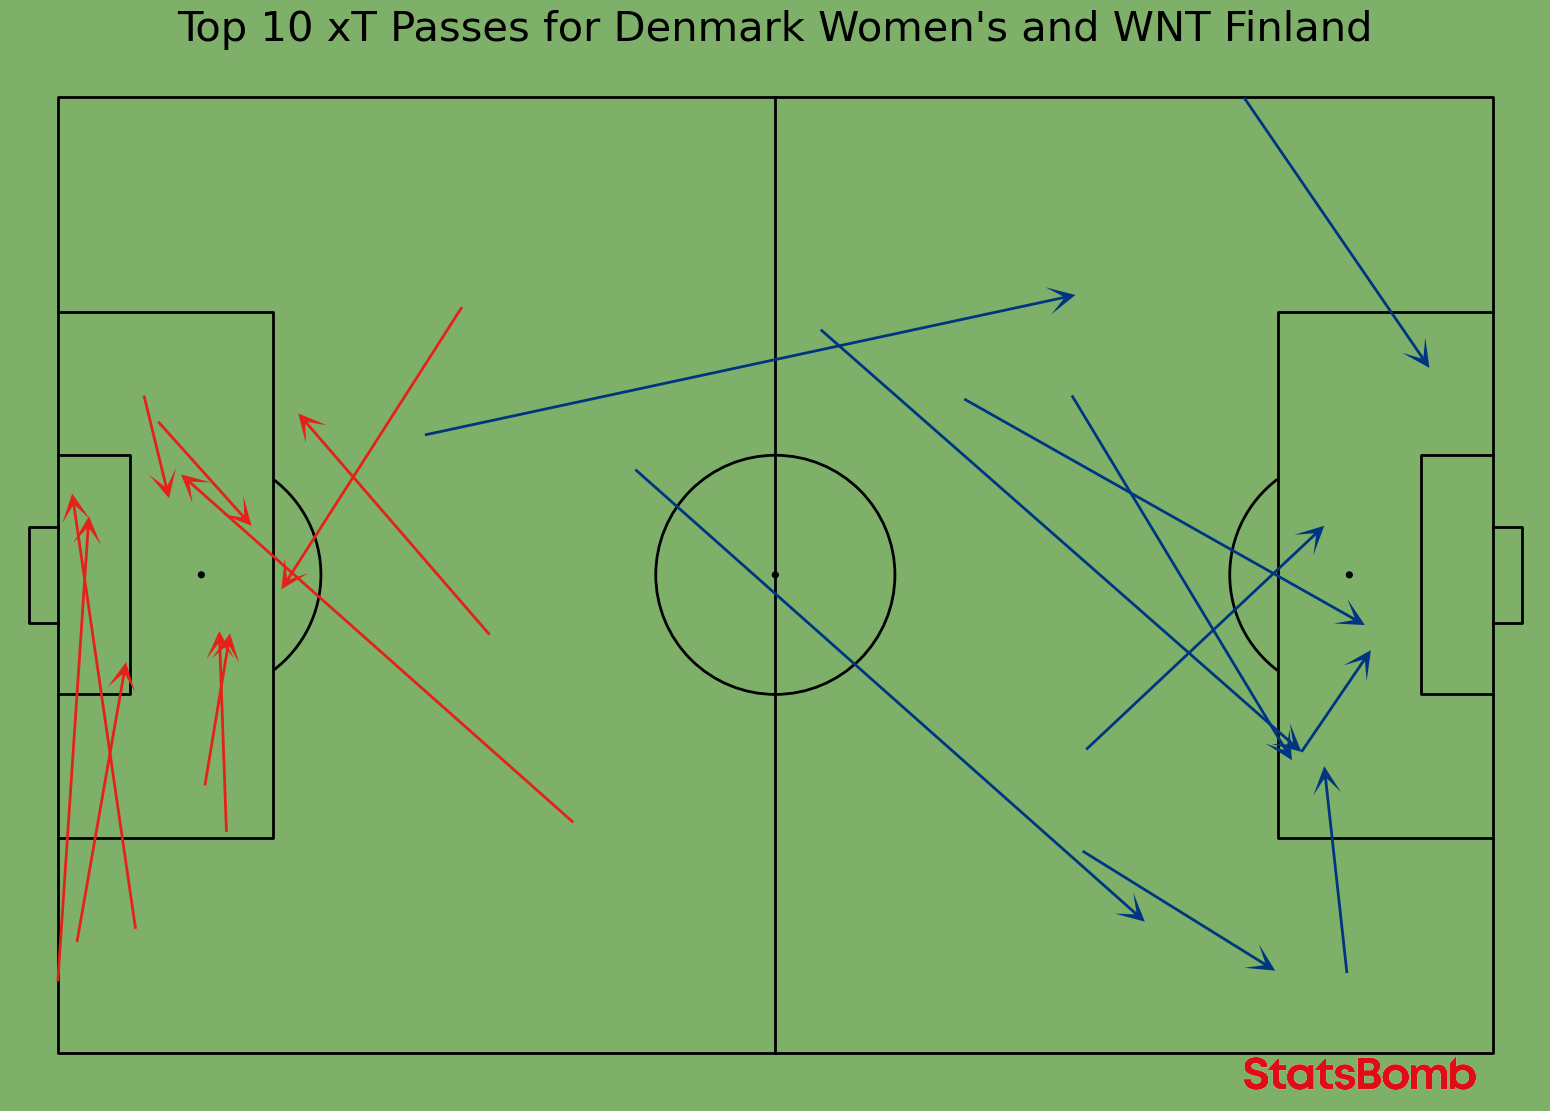

In [91]:
pitch = Pitch(pitch_type='statsbomb', pitch_color=pitchColor, line_color=linesColor, goal_type="box",)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(figColor)


xt_den = passes[passes["team"]==hteam]
xt_den = xt_den.sort_values(by =["xT"], ascending =False)
xt_den = xt_den.head(10) 

xT_den_reverseX = xt_den.copy()
xT_den_reverseX['x_start'] = pitch.dim.right - xT_den_reverseX.x_start
xT_den_reverseX['x_end'] = pitch.dim.right - xT_den_reverseX.x_end

xt_fin = passes[passes["team"]==ateam]
xt_fin = xt_fin.sort_values(by =["xT"], ascending =False)
xt_fin = xt_fin.head(10) 

pitch.arrows(xT_den_reverseX.x_start, xT_den_reverseX.y_start,
             xT_den_reverseX.x_end, xT_den_reverseX.y_end, width=2,
             headwidth=10, headlength=10, color= hteamColor, ax=ax, alpha = 1)
pitch.arrows(xt_fin.x_start, xt_fin.y_start,
             xt_fin.x_end, xt_fin.y_end, width=2,
             headwidth=10, headlength=10, color= ateamColor, ax=ax, alpha = 1)


ax.set_title(f"Top 10 xT Passes for {hteam} and {ateam}", fontsize=30, color=textColor)



ax3 = fig.add_axes([0.73, 0.014, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

#plt.savefig(f'viz/Top 10 xT Passes for {hteam} and {ateam} During {tournament}', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, "Pass Map Denmark Women's")

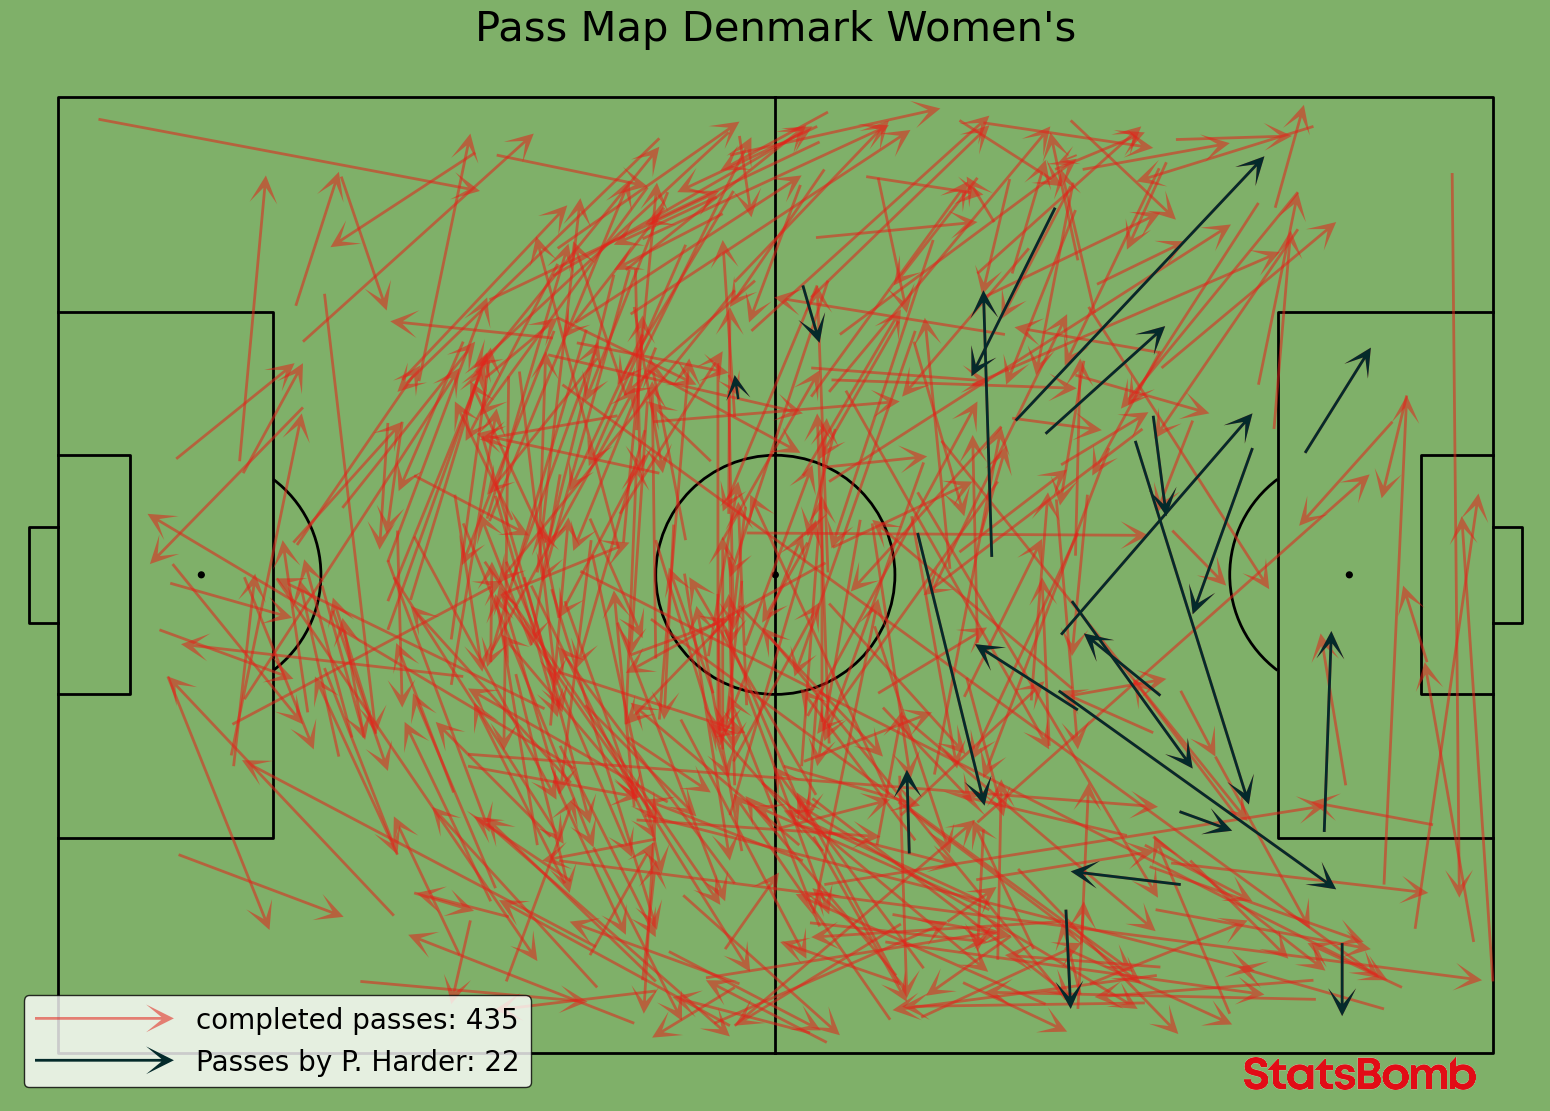

In [92]:
pitch = Pitch(pitch_type='statsbomb', pitch_color=pitchColor, line_color=linesColor, goal_type="box",)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(figColor)


pitch.arrows(pass_den.x_start, pass_den.y_start,
             pass_den.x_end, pass_den.y_end, width=2,
             headwidth=10, headlength=10, color= hteamColor, ax=ax, label=f'completed passes: {countPassDen}', alpha = .55)

pitch.arrows(passHarder.x_start, passHarder.y_start,
             passHarder.x_end, passHarder.y_end, width=2,
             headwidth=10, headlength=10, color='#042A2B', ax=ax, label=f'Passes by P. Harder: {countPassHarder}', alpha = 1)


ax.legend(facecolor='white', handlelength=5, edgecolor='black', fontsize=20, loc='lower left')

ax3 = fig.add_axes([0.73, 0.014, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

ax.set_title(f"Pass Map {hteam}", fontsize=30, color=textColor)

#plt.savefig(f'viz/Pass Map {hteam}', dpi=300, bbox_inches='tight')

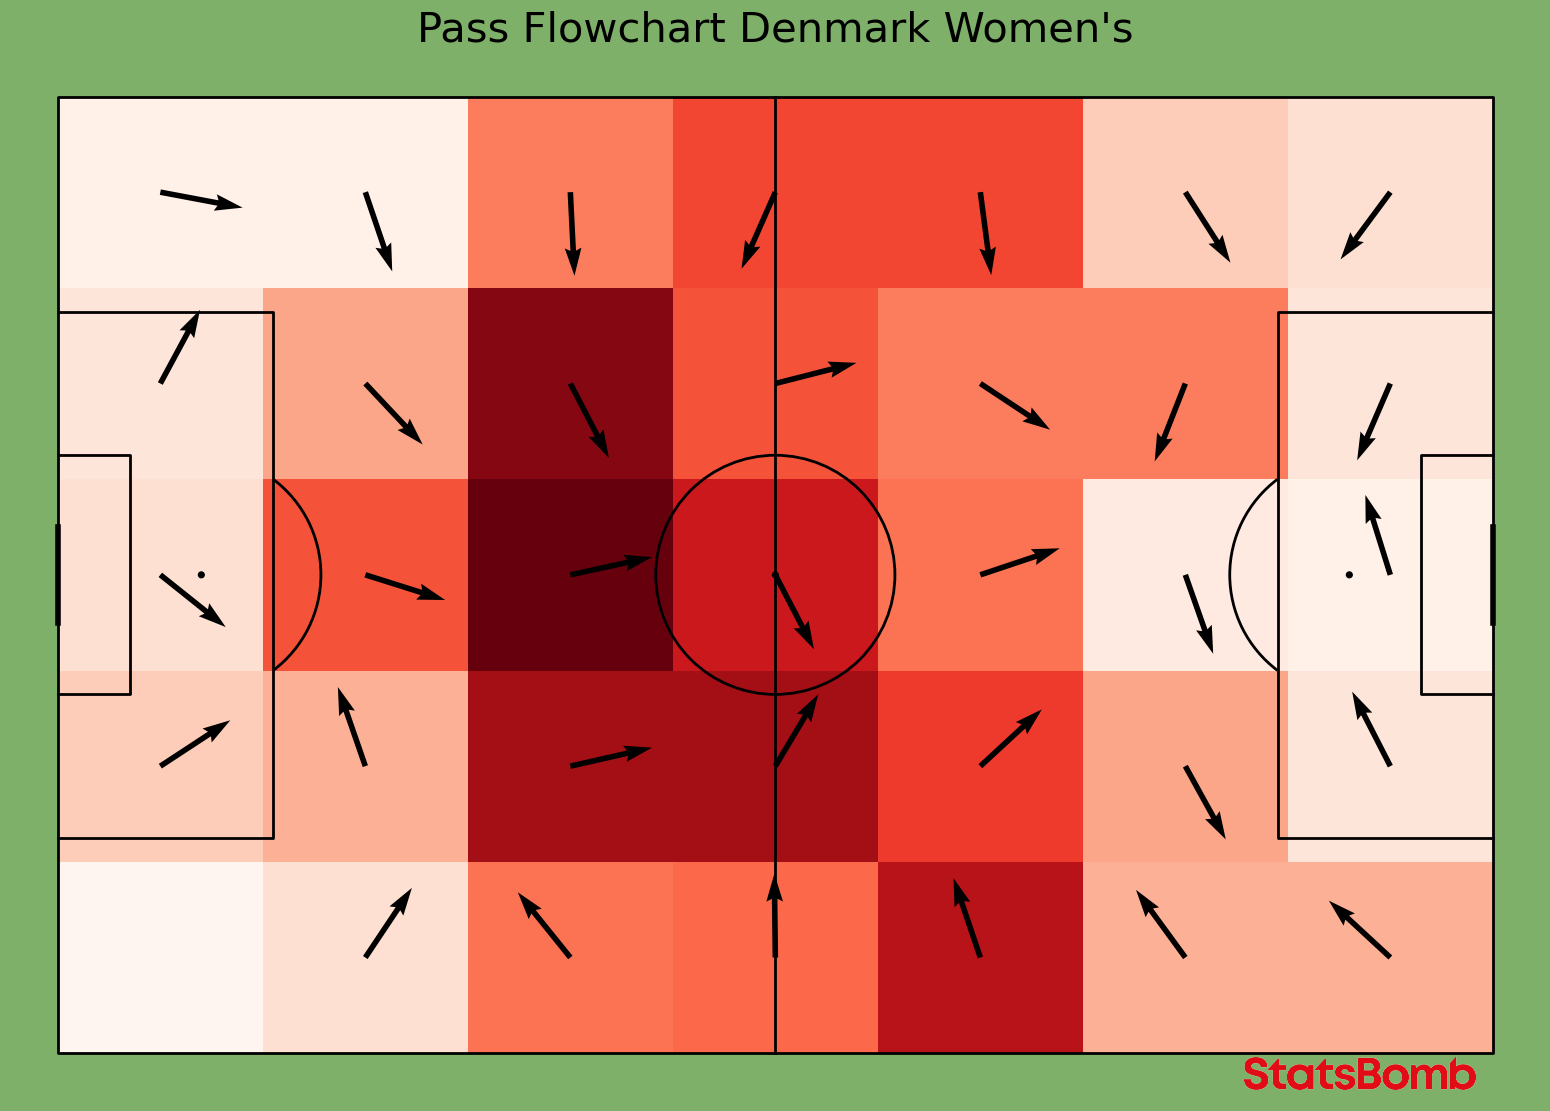

In [93]:
pitch = Pitch(pitch_type='statsbomb',  line_zorder=2, line_color=linesColor, pitch_color=pitchColor)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(pitchColor)

bins = (7, 5)

bs_heatmap = pitch.bin_statistic(pass_den.x_start, pass_den.y_start, statistic='count', bins=bins)
hm = pitch.heatmap(bs_heatmap, ax=ax, cmap='Reds')

fm = pitch.flow(pass_den.x_start, pass_den.y_start, pass_den.x_end, pass_den.y_end,
                color='black', arrow_type='same',
                arrow_length=7, bins=bins, ax=ax)

ax.set_title(f"Pass Flowchart {hteam}", fontsize=30, color=textColor)

ax3 = fig.add_axes([0.73, 0.014, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

#plt.savefig(f'viz/Pass Flowchart {hteam}', dpi=300, bbox_inches='tight')

In [94]:
pass_fin = df[df.type == "Pass"]
pass_fin = pass_fin[pass_fin.team == ateam]
pass_fin = pass_fin[(pass_fin["pass_type"]!="Kick Off") & (pass_fin["pass_type"]!="Goal Kick") 
                    & (pass_fin["pass_type"]!="Free Kick") & (pass_fin["pass_type"]!="Throw-in") 
                    & (pass_fin["pass_type"]!="Corner") & (pass_fin["pass_outcome"]!="Incomplete") 
                    & (pass_fin["pass_outcome"]!="Pass Offisde") & (pass_fin["pass_outcome"]!="Out") 
                    & (pass_fin["pass_outcome"]!="Unknown")]

pass_fin = pass_fin[['team', 'player', "player_id", 'minute', 'second', 'location', "pass_type", "pass_outcome",
                     "pass_end_location", "type", "pass_assisted_shot_id"]]

pass_fin['x_start'] = pass_fin.location.apply(lambda x: x[0])
pass_fin['y_start'] = pass_fin.location.apply(lambda x: x[1])

pass_fin['x_end'] = pass_fin.pass_end_location.apply(lambda x: x[0])
pass_fin['y_end'] = pass_fin.pass_end_location.apply(lambda x: x[1])
pass_fin = pass_fin.drop('location', axis=1)
pass_fin = pass_fin.drop('pass_end_location', axis=1)

countPass_fin = pass_fin.shape[0]

Text(0.5, 1.0, 'Pass Map for WNT Finland')

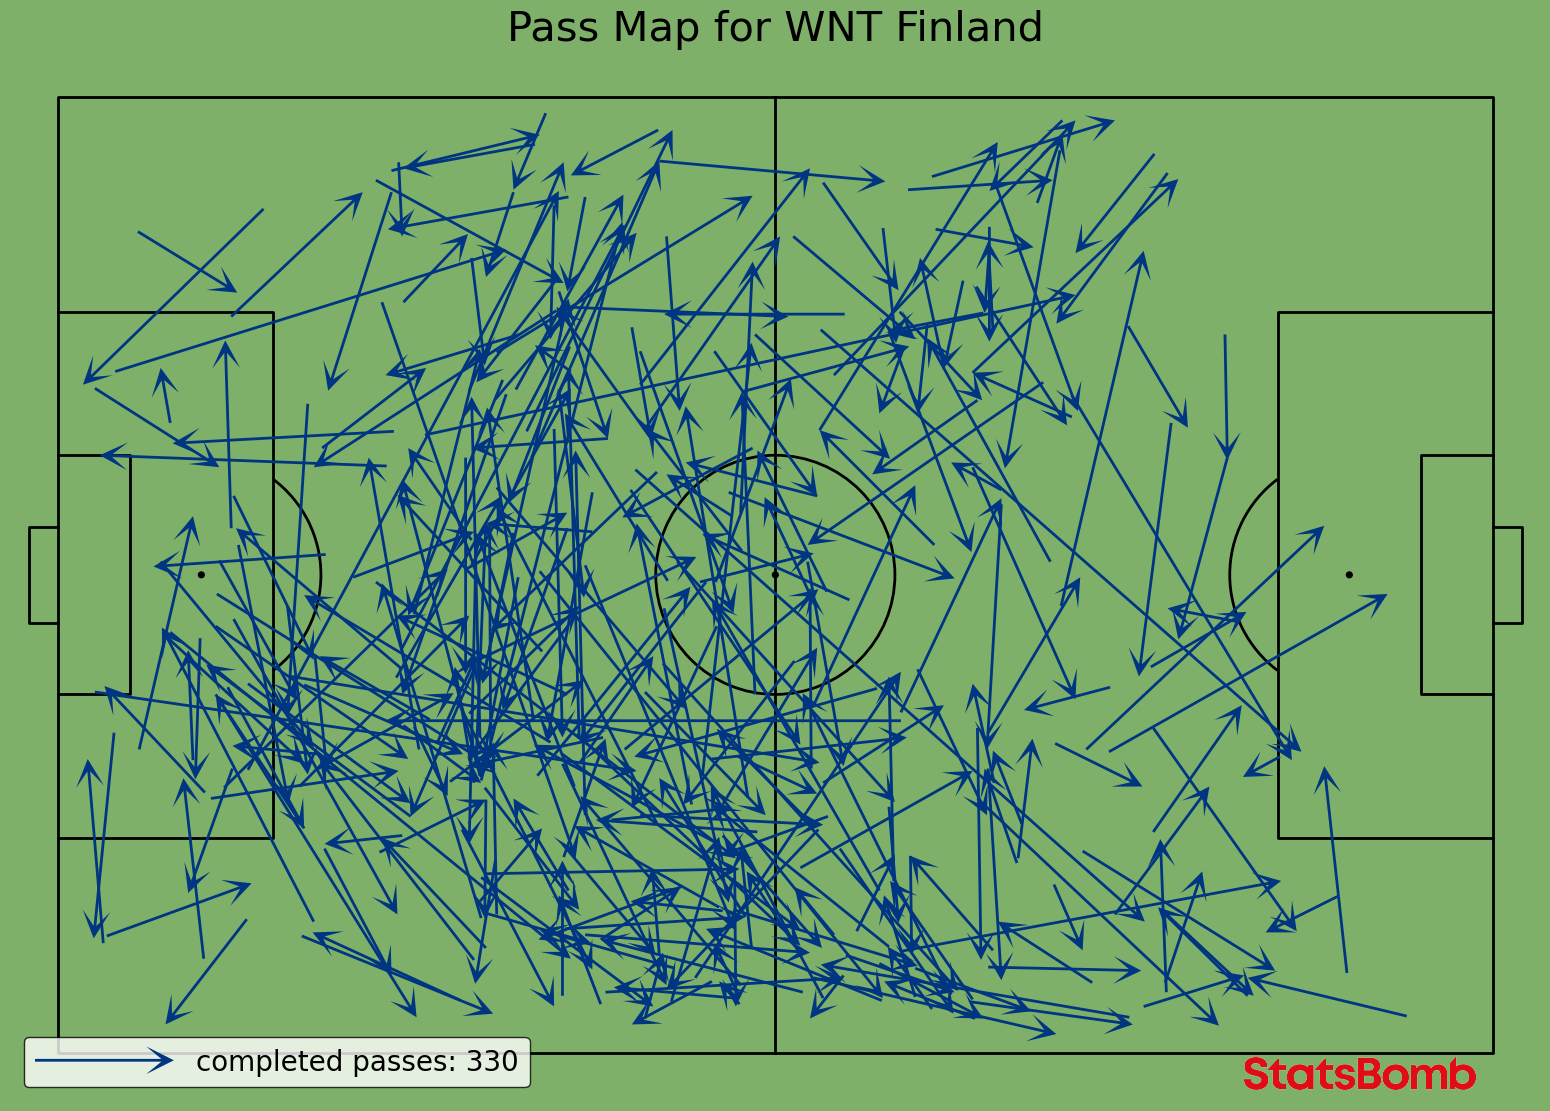

In [95]:
pitch = Pitch(pitch_type='statsbomb', pitch_color=pitchColor, line_color=linesColor, goal_type="box",)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(figColor)


pitch.arrows(pass_fin.x_start, pass_fin.y_start,
             pass_fin.x_end, pass_fin.y_end, width=2,
             headwidth=10, headlength=10, color=ateamColor, ax=ax, label=f'completed passes: {countPass_fin}', alpha = 1)


ax.legend(facecolor='white', handlelength=5, edgecolor='black', fontsize=20, loc='lower left')

ax3 = fig.add_axes([0.73, 0.014, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

ax.set_title(f"Pass Map for {ateam}", fontsize=30, color=textColor)

#plt.savefig(f'viz/Pass Map {ateam}', dpi=300, bbox_inches='tight')

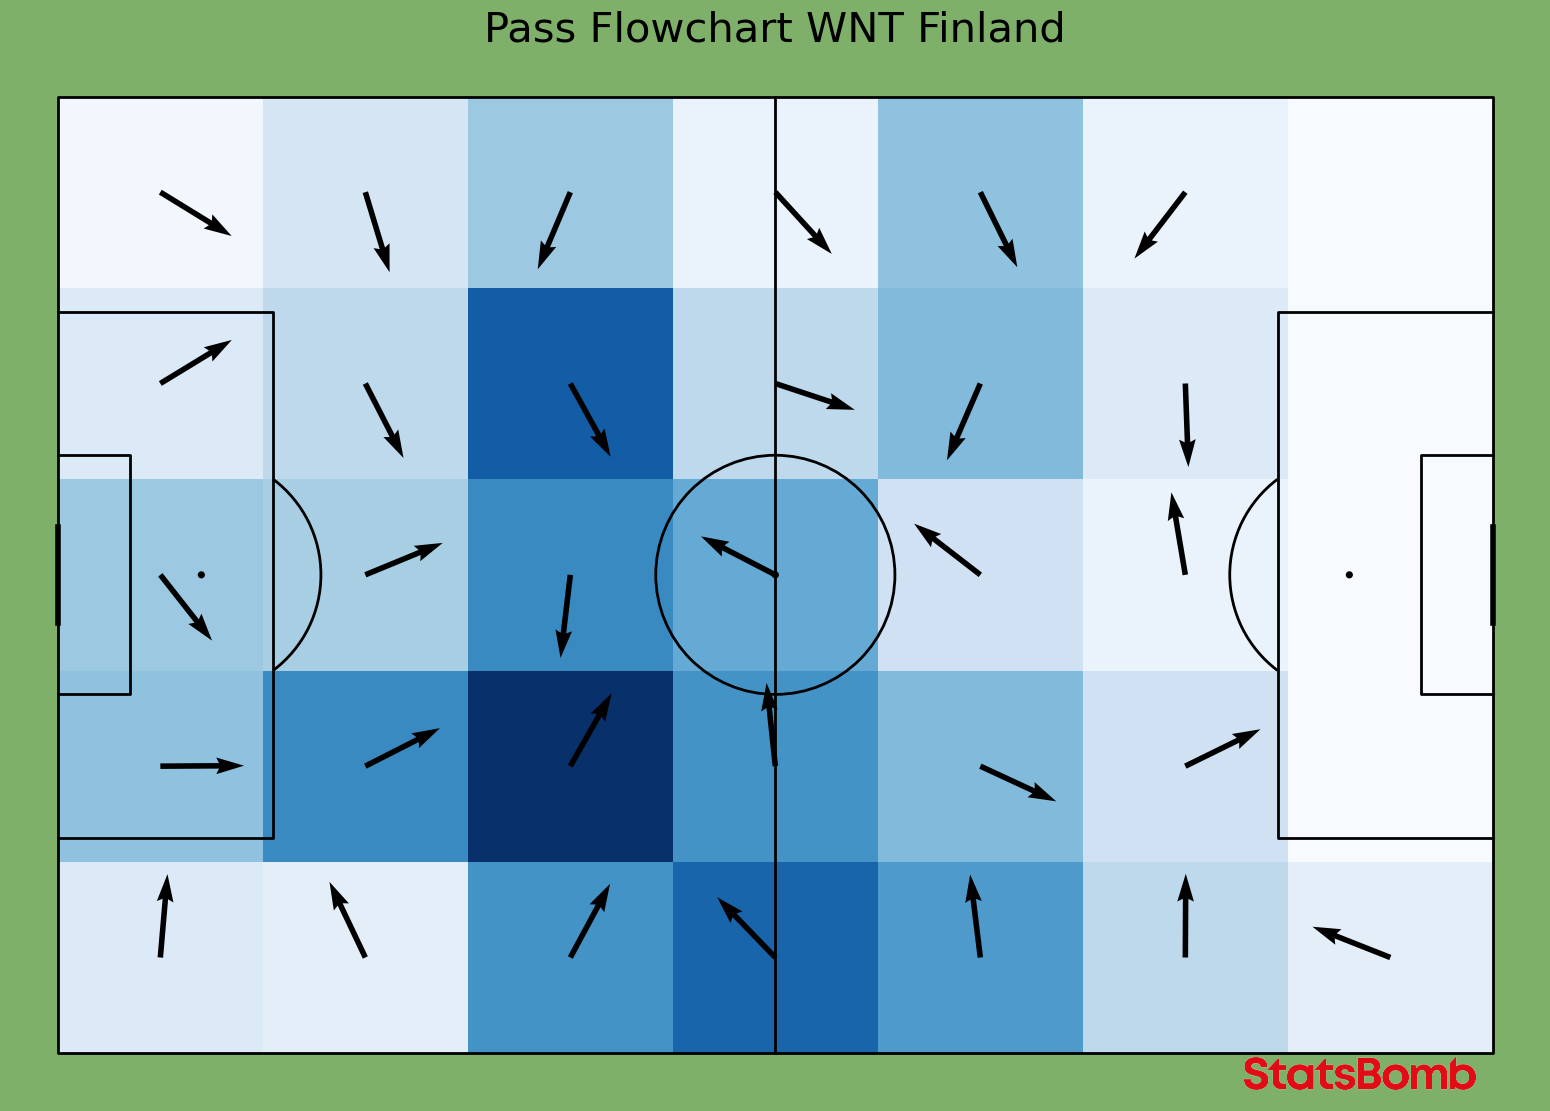

In [96]:
pitch = Pitch(pitch_type='statsbomb',  line_zorder=2, line_color=linesColor, pitch_color=pitchColor)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(pitchColor)

bs_heatmap = pitch.bin_statistic(pass_fin.x_start, pass_fin.y_start, statistic='count', bins=bins)
hm = pitch.heatmap(bs_heatmap, ax=ax, cmap='Blues')

fm = pitch.flow(pass_fin.x_start, pass_fin.y_start, pass_fin.x_end, pass_fin.y_end,
                color='black', arrow_type='same',
                arrow_length=7, bins=bins, ax=ax)

ax.set_title(f"Pass Flowchart {ateam}", fontsize=30, color=textColor)

ax3 = fig.add_axes([0.73, 0.014, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

#plt.savefig(f'viz/Pass Flowchart {ateam}', dpi=300, bbox_inches='tight')

In [97]:
pass_den_map = pass_den.copy()

pass_den_map["passer"] = pass_den_map["player_id"]
pass_den_map["recipient"] = pass_den_map["player_id"].shift(-1)

subs = dfDen[dfDen["type"] =="Substitution"]
subs = subs["minute"]
firstSub = subs.min()

pass_den_map = pass_den_map[pass_den_map["minute"]<firstSub]

In [98]:
players = dfDen["player"].unique()
starters = players[1:12]

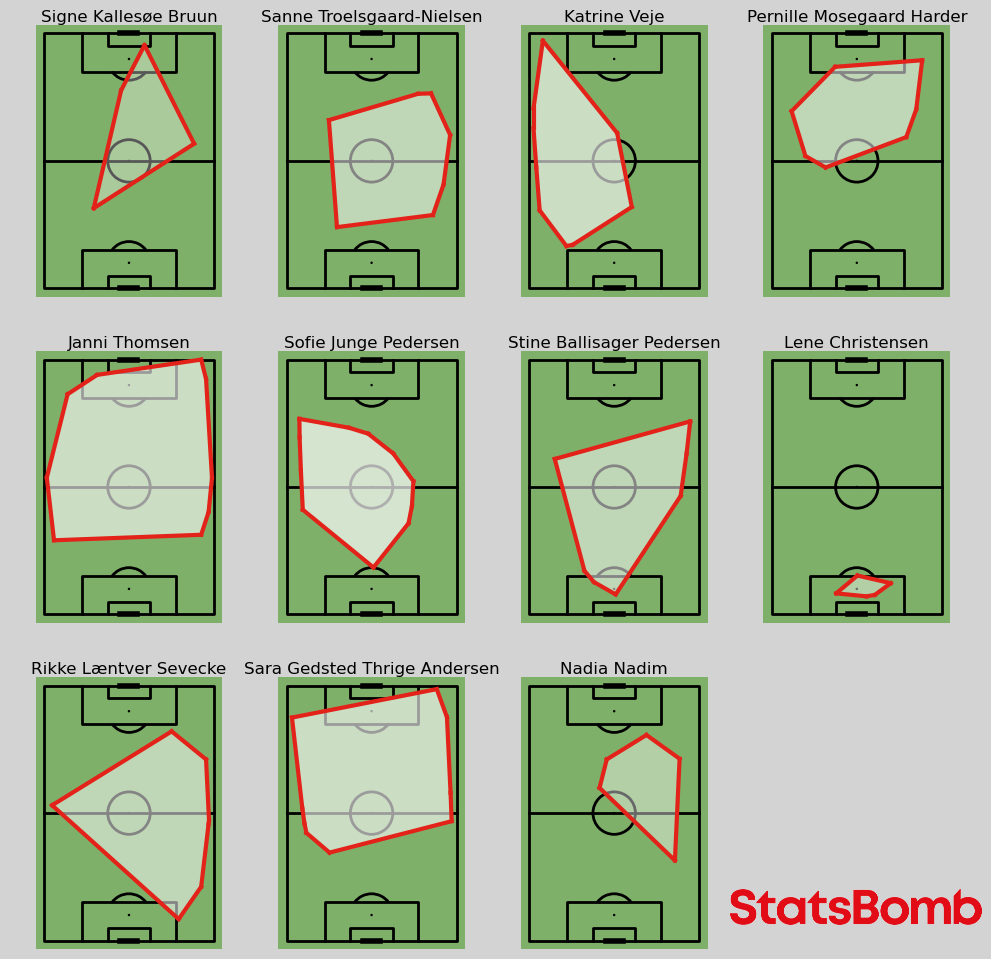

In [116]:
fig, axes = plt.subplots(3,4,figsize=(12,12))
fig.set_facecolor('lightgrey')
axes.flat[-1].set_visible(False)


pitch = VerticalPitch(pitch_type='statsbomb', pitch_color=pitchColor, line_color=linesColor)



for i,ax in enumerate(fig.axes):
    try:
        ax.set_facecolor("red")
        pitch.draw(ax=ax)

        con = pass_den[(pass_den.player == starters[i])]
        con = con[(np.abs(stats.zscore(con[['x_start','y_start']])) < 4.5)]

        points = con[['y_start','x_start']].values
        hull = ConvexHull(con[['x_start','y_start']])

        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], hteamColor,lw=3)
            ax.fill(points[hull.vertices,0], points[hull.vertices,1], c='white', alpha=0.1)
            ax.set_ylabel(ylabel=' ')


        ax.set_title(label=starters[i],c='black',va='center',ha='center',fontsize=12)
    except:
        pass
    
ax3 = fig.add_axes([0.68, 0.13, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

#plt.savefig(f'viz/Pass Convex Hull for {hteam}', dpi=300, bbox_inches='tight')

In [117]:
starting_player_numbers = ["9", "11", "10", "7", "13", "4", "20", "2", "3", "19", "1"]

average_locations = pass_den_map.groupby("passer").agg({"x_start":["mean"], "y_start": ["mean", "count"]})
average_locations.columns = ["x_start","y_start", "count", ]
average_locations["jersey_number"] = starting_player_numbers
average_locations.sort_values(by="passer", ascending=True)

harder_location = average_locations[average_locations["jersey_number"]== "10"]

pass_between = pass_den_map.groupby(["passer", "recipient"]).player_id.count().reset_index()
pass_between.rename({"player_id": "pass_count"},axis="columns", inplace=True)

pass_between = pass_between.merge(average_locations, left_on="passer", right_index = True)
pass_between = pass_between.merge(average_locations, left_on="recipient", right_index = True, suffixes=["","_end"])

MAX_LINE_WIDTH = 14
MAX_MARKER_SIZE = 3000
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           MAX_LINE_WIDTH)
average_locations['marker_size'] = (average_locations['count']
                                         / average_locations['count'].max() * MAX_MARKER_SIZE)
harder_location['marker_size'] = (average_locations['count']
                                         / average_locations['count'].max() * MAX_MARKER_SIZE)

MIN_TRANSPARENCY = 0.7
color = np.array(to_rgba('white'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

C:\Users\Gusse\AppData\Local\Temp\ipykernel_4560\660942509.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harder_location['marker_size'] = (average_locations['count']


In [118]:
average_locations

x_start    y_start  count jersey_number  marker_size
passer                                                          
4650.0    79.133333  56.844444      9             9   402.985075
10088.0   54.992593  20.614815     54            11  2417.910448
10108.0   85.617647  44.364706     17            10   761.194030
10109.0   63.502703  53.397297     37             7  1656.716418
10275.0   61.130769  32.600000     26            13  1164.179104
15789.0   51.111321  58.447170     53             4  2373.134328
24460.0   79.342857  48.642857      7            20   313.432836
32223.0   78.426087  41.047826     23             2  1029.850746
87185.0   45.552239  41.759701     67             3  3000.000000
87195.0   71.766667  34.094444     18            19   805.970149
276442.0  12.485714  46.857143      7             1   313.432836

Text(0.5, 1.0, "Pass Network Denmark Women's")

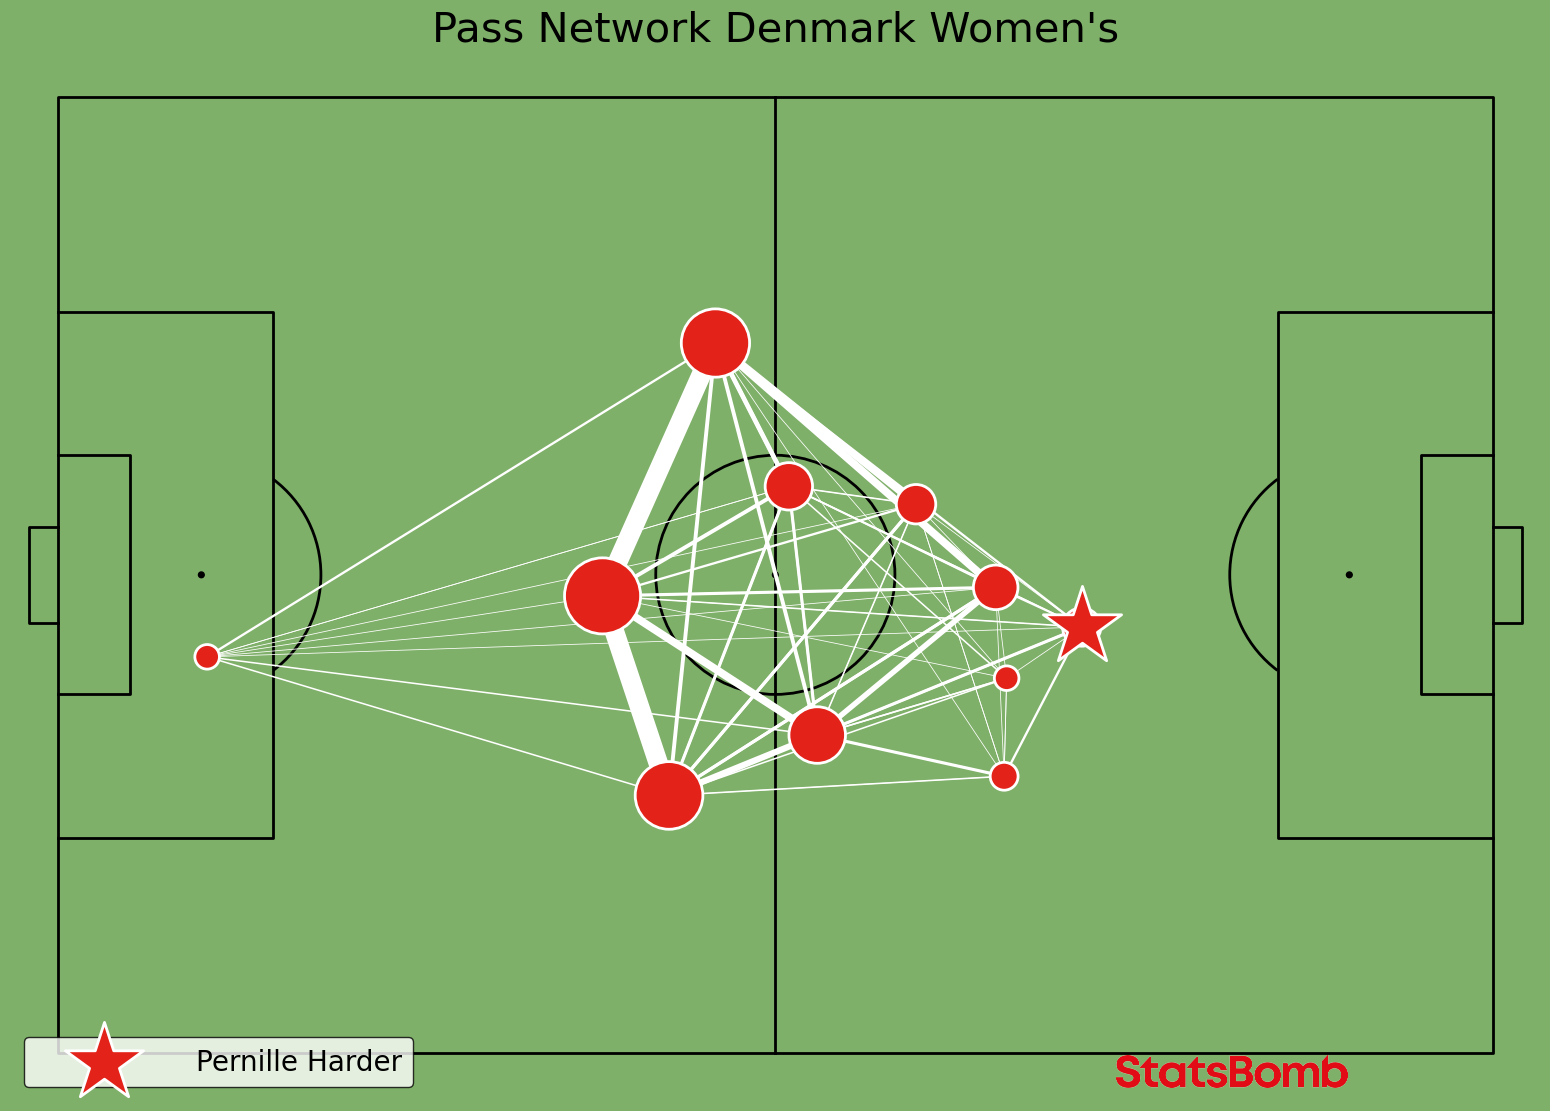

In [119]:
pitch = Pitch(pitch_type='statsbomb', goal_type="box", pitch_color=pitchColor, line_color=linesColor)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(figColor)


pass_lines = pitch.lines(pass_between.x_start, pass_between.y_start,
                         pass_between.x_start_end, pass_between.y_start_end, lw=pass_between.width,
                         color="white", zorder=1, ax=ax)


pass_nodes = pitch.scatter(average_locations.x_start, average_locations.y_start,
                           s=average_locations.marker_size,
                           color=hteamColor, edgecolors='#FFFFFF', linewidth=2, alpha=1, ax=ax)


harder = pitch.scatter(harder_location.x_start, harder_location.y_start,
                           s=3500,
                           marker= "*", color=hteamColor, edgecolors='#FFFFFF', linewidth=2, alpha=1,
                       ax=ax, label = "Pernille Harder")

ax.legend(facecolor='white', handlelength=5, edgecolor='black', fontsize=20, loc='lower left')

ax3 = fig.add_axes([0.65, 0.016, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

ax.set_title(f"Pass Network {hteam}", fontsize=30, color=textColor)

#plt.savefig(f'viz/Pass Network, {hteam}', dpi=300, bbox_inches='tight')

In [120]:
pass_fin_map = pass_fin

pass_fin_map["passer"] = pass_fin_map["player_id"]
pass_fin_map["recipient"] = pass_fin_map["player_id"].shift(-1)

subsFin = dfFin[dfFin["type"] =="Substitution"]
subsFin = subsFin["minute"]
firstSubFin = subsFin.min()

pass_fin_map = pass_fin_map[pass_fin_map["minute"]<firstSubFin]

In [121]:
average_locationsFin = pass_fin_map.groupby("passer").agg({"x_start":["mean"], "y_start": ["mean", "count"]})
average_locationsFin.columns = ["x_start","y_start", "count", ]
average_locationsFin.sort_values(by="passer", ascending=True)


pass_betweenFin = pass_fin_map.groupby(["passer", "recipient"]).player_id.count().reset_index()
pass_betweenFin.rename({"player_id": "pass_count"},axis="columns", inplace=True)

pass_betweenFin = pass_betweenFin.merge(average_locationsFin, left_on="passer", right_index = True)
pass_betweenFin = pass_betweenFin.merge(average_locationsFin, left_on="recipient", right_index = True, suffixes=["","_end"])


MAX_LINE_WIDTH_FIN = 14
MAX_MARKER_SIZE_FIN = 2500
pass_betweenFin['width'] = (pass_betweenFin.pass_count / pass_betweenFin.pass_count.max() *
                           MAX_LINE_WIDTH_FIN)
average_locationsFin['marker_size'] = (average_locationsFin['count']
                                         / average_locationsFin['count'].max() * MAX_MARKER_SIZE_FIN)

Text(0.5, 1.0, 'Pass Network For WNT Finland')

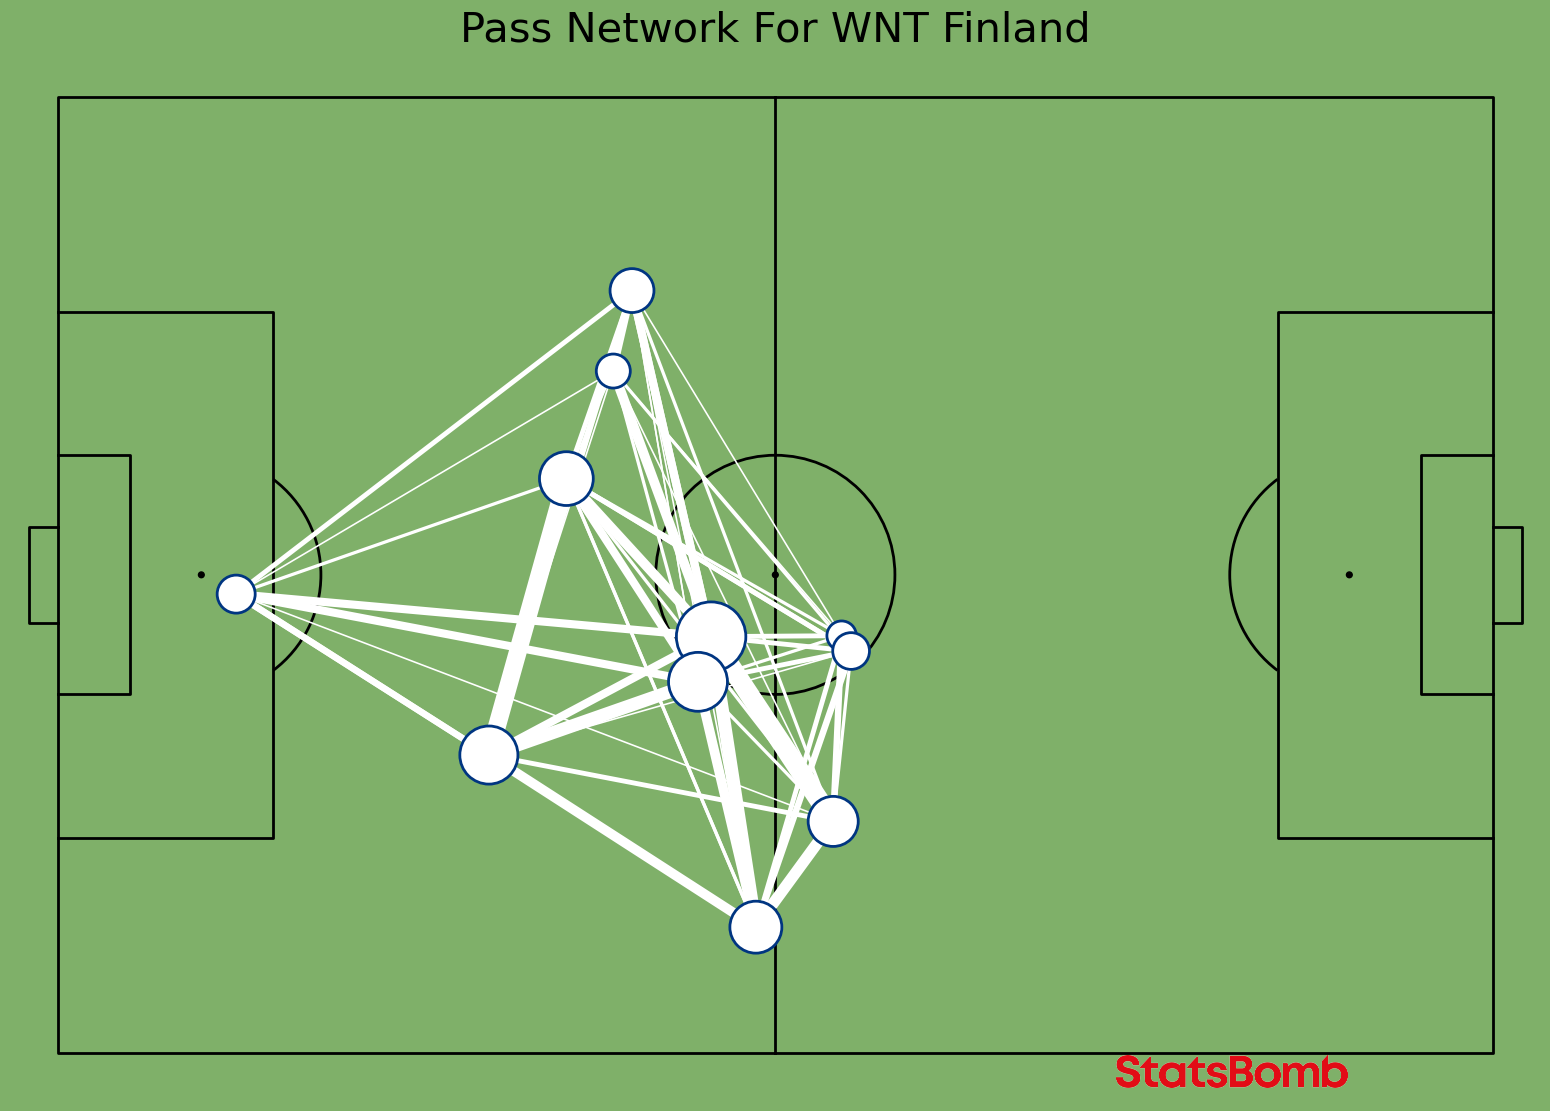

In [122]:
pitch = Pitch(pitch_type='statsbomb', goal_type="box", pitch_color=pitchColor, line_color=linesColor)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(figColor)


pass_lines = pitch.lines(pass_betweenFin.x_start, pass_betweenFin.y_start,
                         pass_betweenFin.x_start_end, pass_betweenFin.y_start_end, lw=pass_betweenFin.width,
                         zorder=1, ax=ax, color= "white")


pass_nodes = pitch.scatter(average_locationsFin.x_start, average_locationsFin.y_start,
                           s=average_locationsFin.marker_size,
                           color= "white", edgecolors=ateamColor, linewidth=2, alpha=1, ax=ax, label = "Finland Player")
ax3 = fig.add_axes([0.65, 0.016, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)


ax.set_title(f"Pass Network For {ateam}", fontsize=30, color=textColor)

#plt.savefig(f'viz/Pass Network, {ateam}', dpi=300, bbox_inches='tight')

In [123]:
harderEvents = df[df["player_id"]== MVP]
harderEvents = harderEvents[(harderEvents["type"]!= 'Ball Receipt*') & (harderEvents["type"]!= 'Injury Stoppage') 
                            & (harderEvents["type"]!= 'Player Off') & (harderEvents["type"]!= 'Player On') 
                            & (harderEvents["type"]!= 'Substitution') & (harderEvents["type"]!= 'Miscontrol')]

harderEvents = harderEvents[[ 'player',"player_id", 'minute', 'second', 'location',  "type", 
                             "under_pressure", "dribble_outcome", "duel_type"]]

harderEvents['x'] = harderEvents.location.apply(lambda x: x[0])
harderEvents['y'] = harderEvents.location.apply(lambda x: x[1])
harderEvents = harderEvents.drop('location', axis=1)

BallRecovery = harderEvents[harderEvents.type == 'Ball Recovery']
Interception = harderEvents[harderEvents.type == 'Interception']
Dribble = harderEvents[harderEvents.type == 'Dribble']
Tackle = harderEvents[harderEvents.duel_type == "Tackle"]

countBallRecovery = BallRecovery.shape[0]
countInterception = Interception.shape[0]
countDribble = Dribble.shape[0]
countTackle = Tackle.shape[0]

xgDen = dfDen["shot_statsbomb_xg"].sum()

In [124]:
harderURL = "https://images.fotmob.com/image_resources/playerimages/200707.png"
response = requests.get(harderURL)
harderPic = Image.open(BytesIO(response.content))

In [125]:
dbuURL = "https://brandslogos.com/wp-content/uploads/images/large/dbu-logo.png"
response = requests.get(dbuURL)
DBU = Image.open(BytesIO(response.content))

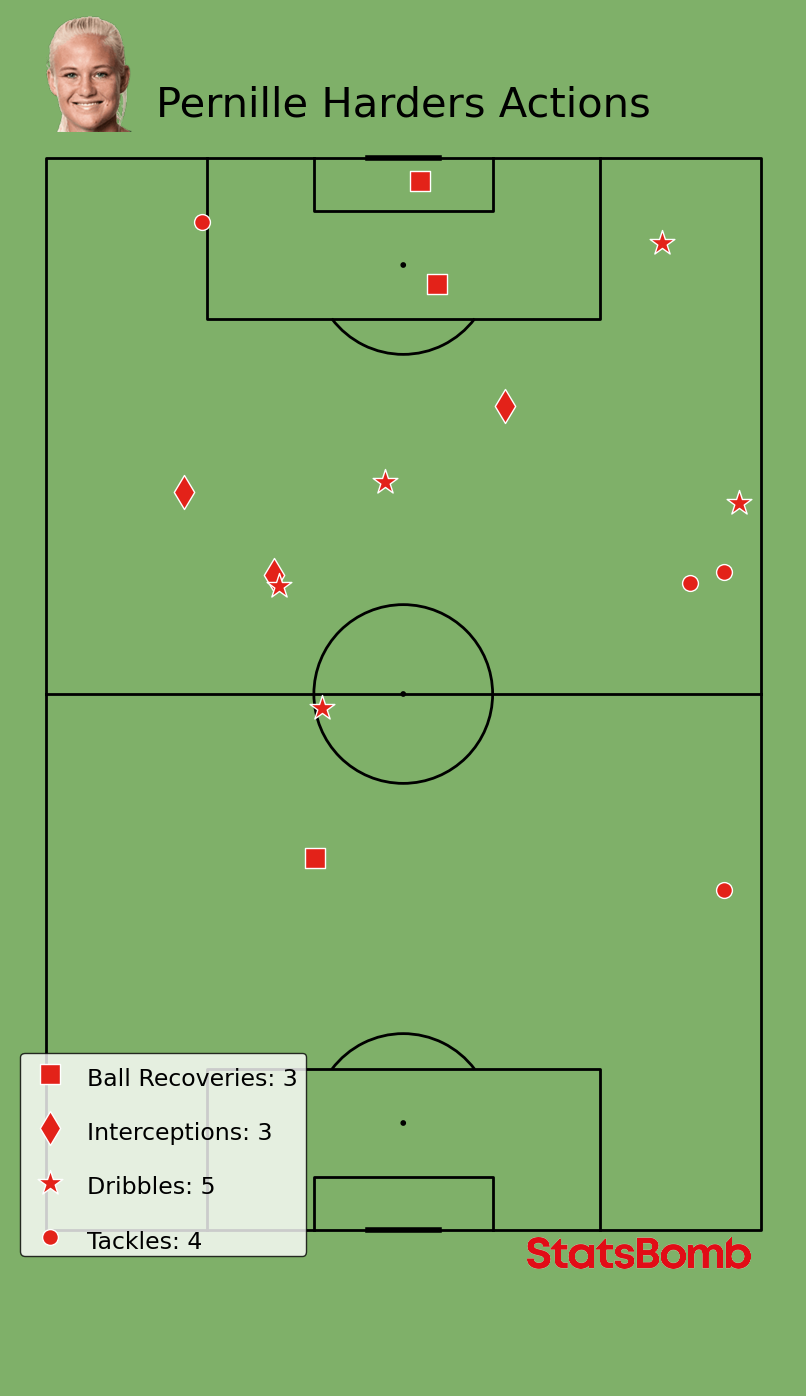

In [126]:
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color=pitchColor, line_color=linesColor)
fig, axs= pitch.grid(figheight=16, title_height=0.06, axis=False)
fig.set_facecolor(figColor)

scatter_recovery = pitch.scatter(BallRecovery.x, BallRecovery.y, c= hteamColor, edgecolor = "white",
                                 s=200, marker='s',  ax=axs['pitch'], 
                                 label = f"Ball Recoveries: {countBallRecovery}")

scatter_interception = pitch.scatter(Interception.x, Interception.y, c= hteamColor,
                                     s=300, marker='d', edgecolor = "white", ax=axs['pitch'], 
                                     label = f"Interceptions: {countInterception}")

scatter_dribble = pitch.scatter(Dribble.x, Dribble.y, c= hteamColor, edgecolor= "white",
                                s=350, marker='*',  ax=axs['pitch'], 
                                label = f"Dribbles: {countDribble}")

scatter_tackle = pitch.scatter(Tackle.x, Tackle.y, c=hteamColor, edgecolor= "white",
                               s=520, marker=".",  ax=axs['pitch'], 
                               label = f"Tackles: {countTackle}")

axs["title"].text (0.5, 0.01, f"{MVPname}s Actions", color= textColor, va="center", ha="center", fontsize=30)


ax3 = fig.add_axes([0.65, 0.033, 0.27, 0.24])
ax3.axis('off')
ax3.imshow(im)

ax4 = fig.add_axes([0.05, 0.77, 0.14, 0.24])
ax4.axis('off')
ax4.imshow(harderPic)

legend = axs['pitch'].legend(loc='lower left', labelspacing=1.5, edgecolor="black")
for text in legend.get_texts():
    text.set_fontsize(17)
    text.set_va('center')


#plt.savefig(f'viz/{MVPname} Actions, Denmark v Finland', dpi=300, bbox_inches='tight')

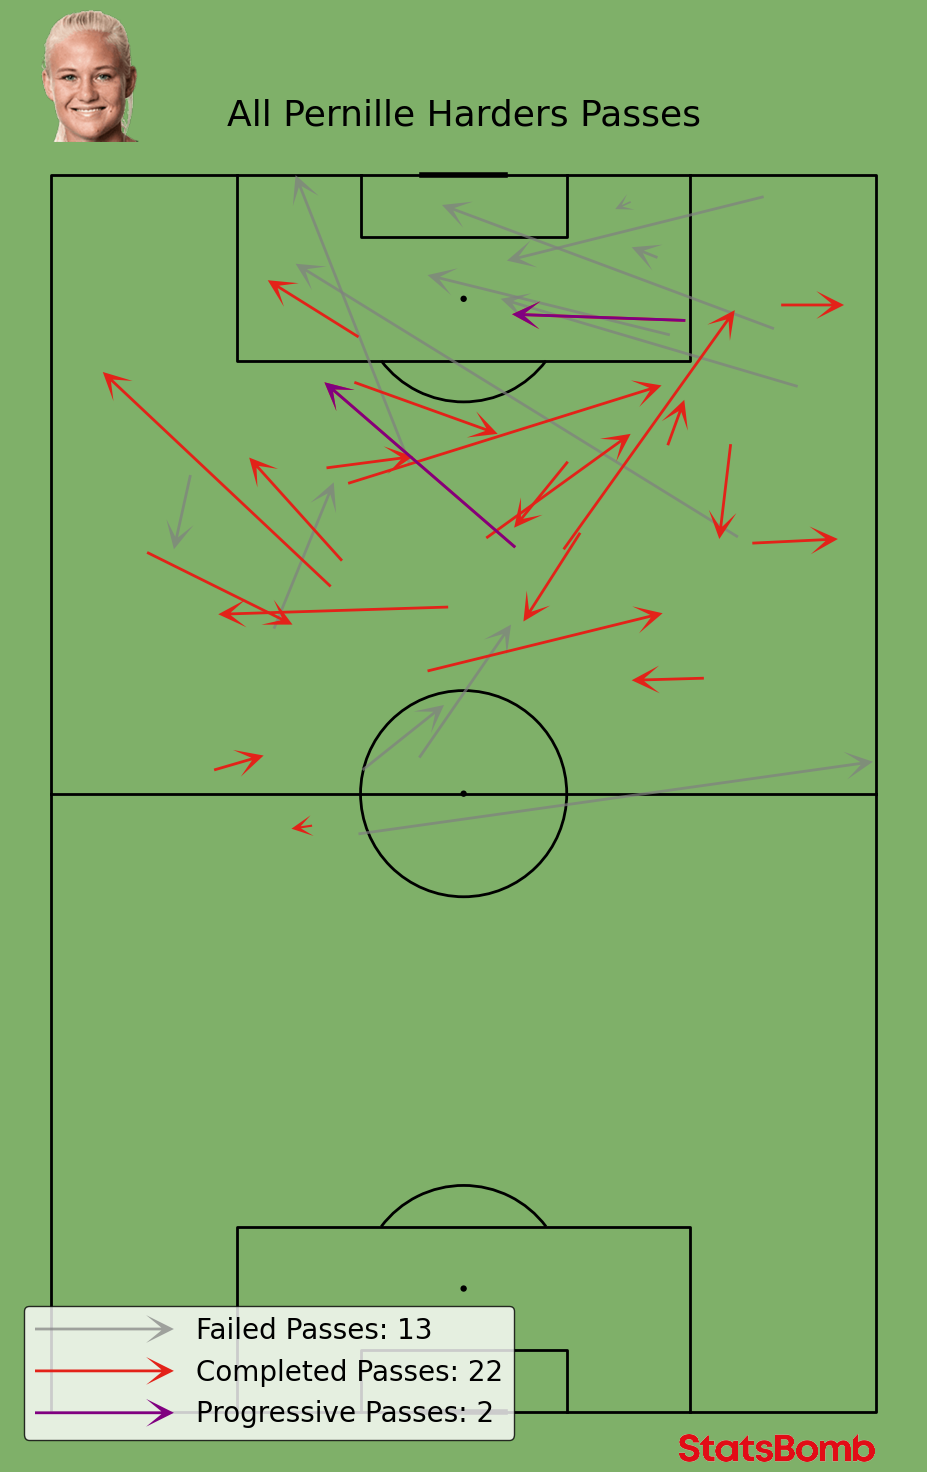

In [127]:
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color=pitchColor,  line_color=linesColor, line_zorder=1)
fig, ax = pitch.draw(figsize=(11, 14))
fig.set_facecolor(pitchColor)

pitch.arrows(passHarder_failed.x_start, passHarder_failed.y_start,
             passHarder_failed.x_end, passHarder_failed.y_end, width=2,
             headwidth=10, headlength=10, color="grey", ax=ax, 
             label=f'Failed Passes: {countFailedHarder}', alpha = .70)


pitch.arrows(passHarder.x_start, passHarder.y_start,
             passHarder.x_end, passHarder.y_end, width=2,
             headwidth=10, headlength=10, color=hteamColor, ax=ax, 
             label=f'Completed Passes: {countPassHarder}', alpha = 1)

pitch.arrows(harderProg.x_start, harderProg.y_start,
             harderProg.x_end, harderProg.y_end, width=2,
             headwidth=10, headlength=10, color="purple", ax=ax, 
             label=f'Progressive Passes: {countProgHarder}', alpha = 1)



ax.set_title(f"All {MVPname}s Passes", fontsize=26, color= textColor)


logo = fig.add_axes([0.65, 0.010, 0.27, 0.02])
logo.axis('off')
logo.imshow(im)

pic = fig.add_axes([0.10, 0.88, 0.12, 0.24])
pic.axis('off')
pic.imshow(harderPic)


ax.legend(facecolor='white', handlelength=5, edgecolor='black', fontsize=20, loc='lower left')

#plt.savefig(f'viz/{MVPname} Passmap', dpi=300, bbox_inches='tight')

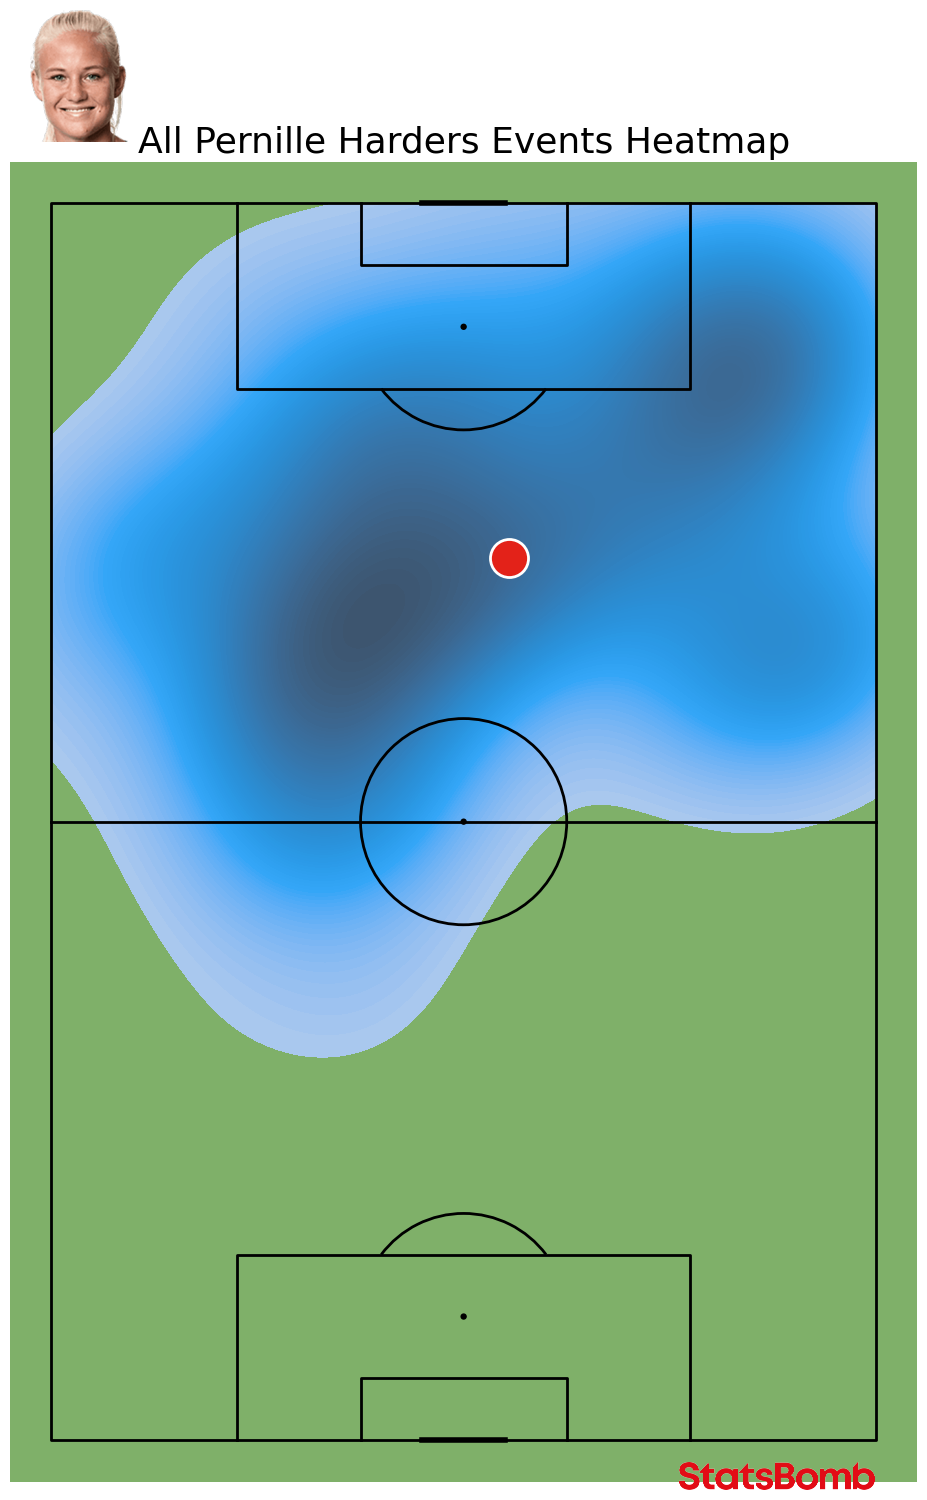

In [128]:
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color=pitchColor,  line_color=linesColor, line_zorder=2)
fig, ax = pitch.draw(figsize=(11, 14))
fig.set_facecolor("white")

kde = pitch.kdeplot(harderEvents.x, harderEvents.y, ax=ax,
                    shade=True, levels=100,
                    shade_lowest=False,
                    cut=4.1,
                    cmaps="Green")

ax.set_title(f"All {MVPname}s Events Heatmap", fontsize=26, color= textColor)

harder = pitch.scatter(harder_location.x_start, harder_location.y_start,
                           s=750,
                           marker= "o", color=hteamColor, edgecolors='#FFFFFF', linewidth=2, alpha=1,
                       ax=ax, label = "Pernille Harder")

logo = fig.add_axes([0.65, 0.010, 0.27, 0.02])
logo.axis('off')
logo.imshow(im)

pic = fig.add_axes([0.09, 0.90, 0.12, 0.24])
pic.axis('off')
pic.imshow(harderPic)

#plt.savefig(f'viz/{MVPname} Heatmap, All Events', dpi=300, bbox_inches='tight')

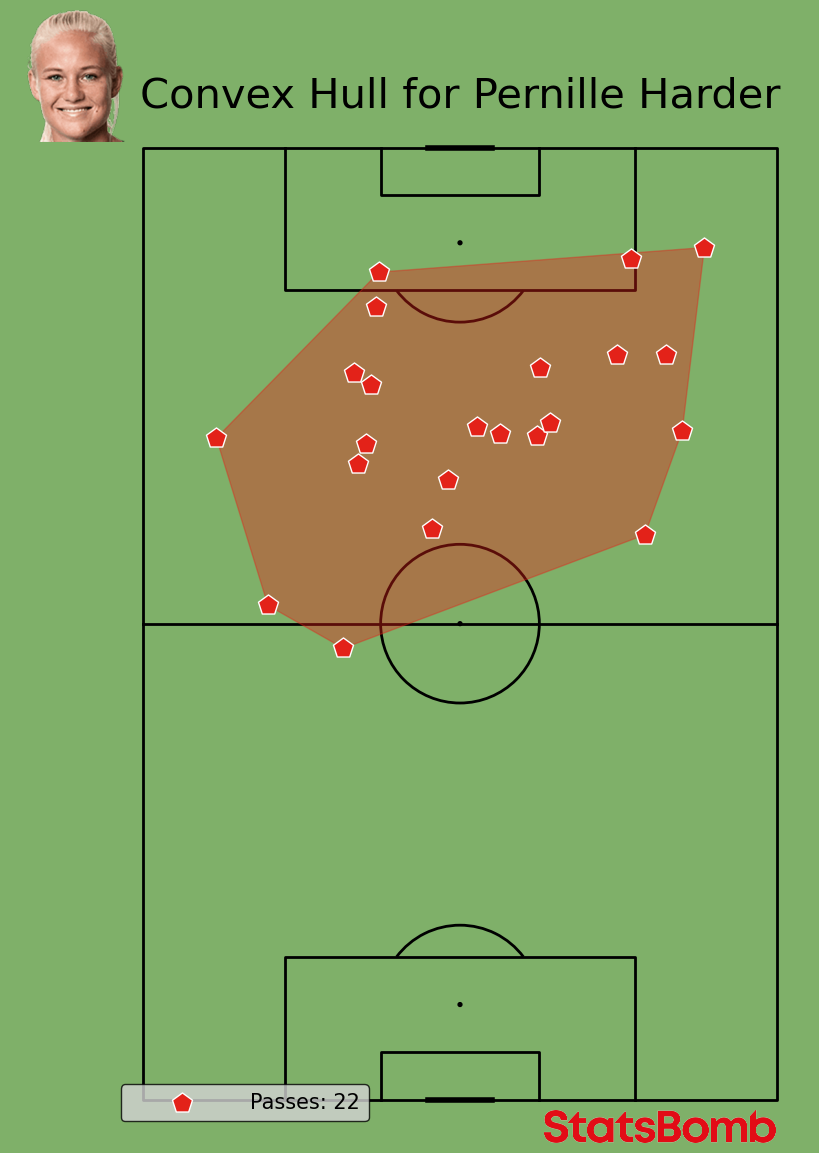

In [129]:
pitch = VerticalPitch(pitch_type='statsbomb',  line_zorder=1, line_color=linesColor, pitch_color=pitchColor)
fig, ax = pitch.draw(figsize=(16, 11))
fig.set_facecolor(pitchColor)
hull = pitch.convexhull(passHarder.x_start, passHarder.y_start)
poly = pitch.polygon(hull, ax=ax, edgecolor=hteamColor, facecolor=hteamColor, alpha=0.4, zorder=1)
scatter = pitch.scatter(passHarder.x_start, passHarder.y_start, ax=ax, marker="p", edgecolor='white', facecolor=hteamColor,
                        s=230, zorder=3, label=f"Passes: {countPassHarder}")


ax.set_title(f"Convex Hull for {MVPname}", fontsize=30, color=textColor)

ax3 = fig.add_axes([0.49, 0.010, 0.27, 0.03])
ax3.axis('off')
ax3.imshow(im)

pic = fig.add_axes([0.20, 0.92, 0.12, 0.12])
pic.axis('off')
pic.imshow(harderPic)

ax.legend(facecolor='lightgrey', handlelength=5, edgecolor='black', fontsize=15, loc='lower left',fancybox=True)

#plt.savefig(f'viz/Pass Convex Hull for {MVPname}', dpi=300, bbox_inches='tight')

In [130]:
URL = 'https://raw.githubusercontent.com/google/fonts/main/apache/roboto/Roboto%5Bwdth,wght%5D.ttf'
URL2 = 'https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab%5Bwght%5D.ttf'
robotto_regular = FontManager(URL)
robboto_bold = FontManager(URL2)

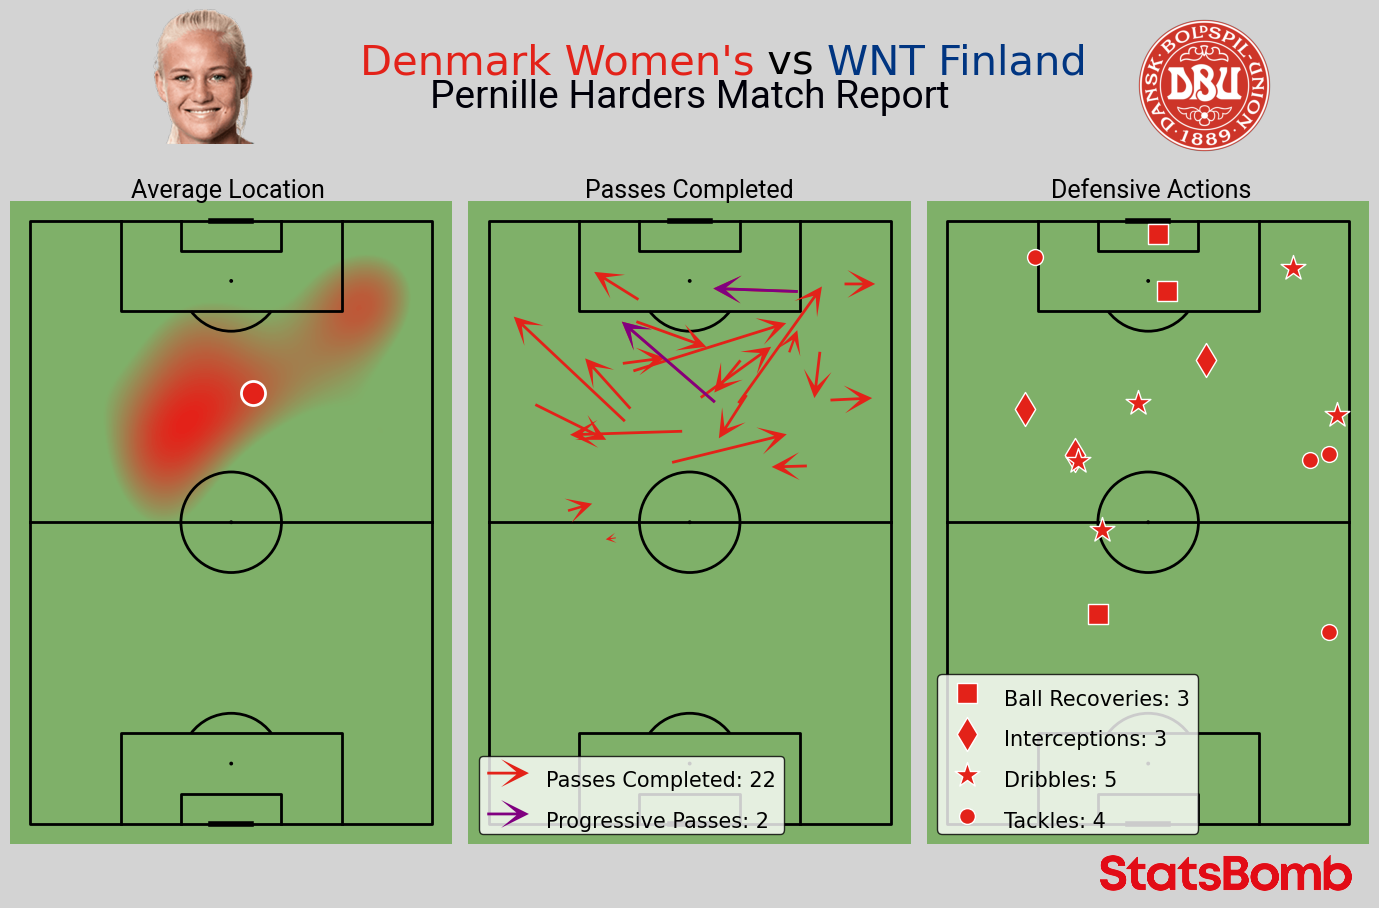

In [131]:
pitch = VerticalPitch(pitch_type='statsbomb',  line_zorder=2, line_color=linesColor, pitch_color=pitchColor)
fig, axs = pitch.grid(ncols=3, axis=False, endnote_height=0.05)
fig.set_facecolor("lightgrey")

axs["title"].text (0.15, 0.01, f"Average Location", color= textColor, va="center", ha="center",
                   fontsize=18, fontproperties=robotto_regular.prop)

axs["title"].text (0.50, 0.01, f"Passes Completed", color= textColor, va="center", ha="center",
                   fontsize=18, fontproperties=robotto_regular.prop)

axs["title"].text (0.85, 0.01, f"Defensive Actions", color= textColor, va="center", ha="center",
                   fontsize=18, fontproperties=robotto_regular.prop)

average_location = pitch.scatter(harder_location.x_start, harder_location.y_start,
                           s=300,
                           marker= "o", color=hteamColor, edgecolors='#FFFFFF', linewidth=2, alpha=1,
                       ax=axs['pitch'][0], zorder=4)

kde = pitch.kdeplot(harderEvents.x, harderEvents.y, ax=axs['pitch'][0],
                    shade=True, levels=100,
                    shade_lowest=False,
                    cut=4.1, thresh=.5,
                    cmap = pitchCmap)


pitch.arrows(passHarder.x_start, passHarder.y_start,
             passHarder.x_end, passHarder.y_end, width=2,
             headwidth=10, headlength=10, color=hteamColor, ax=axs['pitch'][1], alpha = 1, 
             zorder= 2, label =f"Passes Completed: {countPassHarder}")

pitch.arrows(harderProg.x_start, harderProg.y_start,
             harderProg.x_end, harderProg.y_end, width=2,
             headwidth=10, headlength=10, color="purple", ax=axs['pitch'][1], alpha = 1, 
             zorder=2, label =f"Progressive Passes: {countProgHarder}")


scatter_recovery = pitch.scatter(BallRecovery.x, BallRecovery.y, c= hteamColor, edgecolor = "white",
                                 s=200, marker='s',  ax=axs['pitch'][2], 
                                 label = f"Ball Recoveries: {countBallRecovery}", zorder=2)

scatter_interception = pitch.scatter(Interception.x, Interception.y, c= hteamColor,
                                     s=300, marker='d', edgecolor = "white", ax=axs['pitch'][2], 
                                     label = f"Interceptions: {countInterception}", zorder=2)

scatter_dribble = pitch.scatter(Dribble.x, Dribble.y, c= hteamColor, edgecolor= "white",
                                s=350, marker='*',  ax=axs['pitch'][2], 
                                label = f"Dribbles: {countDribble}", zorder=2)

scatter_tackle = pitch.scatter(Tackle.x, Tackle.y, c=hteamColor, edgecolor= "white",
                               s=520, marker=".",  ax=axs['pitch'][2], 
                               label = f"Tackles: {countTackle}", zorder=2)


HighlightText(x=.25, y=19,
              s=f'<{hteam}> vs <{ateam}>', fontsize=30,
              highlight_textprops=[{"color": hteamColor},
                                   {"color": ateamColor}])


TITLE_STR1 = f'{MVPname}s Match Report'
title1_text = axs['title'].text(0.5, 0.7, TITLE_STR1, fontsize=28, color='#000009',
                               fontproperties=robotto_regular.prop,
                                ha='center', va='center')


legend = axs['pitch'][1].legend(loc='lower left', facecolor="white", edgecolor="black", labelspacing=1)
for text in legend.get_texts():
    text.set_fontsize(15)
    text.set_va('center')
    
legend = axs['pitch'][2].legend(loc='lower left', facecolor="white", edgecolor="black", labelspacing=1)
for text in legend.get_texts():
    text.set_fontsize(15)
    text.set_va('center')


pic = fig.add_axes([0.10, 0.87, 0.12, 0.15])
pic.axis('off')
pic.imshow(harderPic)

dbuPic = fig.add_axes([0.80, 0.86, 0.12, 0.15])
dbuPic.axis('off')
dbuPic.imshow(DBU)

sb_logo = fig.add_axes([0.75, 0.04, 0.25, 0.04])
sb_logo.axis('off')
sb_logo.imshow(im)


# plt.savefig(f'viz/{MVPname} Match Report vs {ateam} in {tournament}', dpi=300, bbox_inches='tight')

In [132]:
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter("ignore", NoAuthWarning)


from socceraction.data.statsbomb import StatsBombLoader

SBL = StatsBombLoader(getter="remote", creds=None)

import matplotlib.pyplot as plt

In [133]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [134]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

In [135]:
competitions = SBL.competitions()

In [136]:
selected_comp = competitions[competitions.competition_name == "UEFA Women's Euro"]

In [137]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_comp.itertuples()
])

games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score",]]

home_team_id  away_team_id           game_date  home_score  away_score
0            858           860 2022-07-13 18:00:00           2           1
1            851           858 2022-07-09 21:00:00           1           1
2            865           863 2022-07-20 21:00:00           2           1
3            865           857 2022-07-31 18:00:00           2           1
4            865           858 2022-07-26 21:00:00           4           0
5           2457           865 2022-07-15 21:00:00           0           5
6            864           860 2022-07-09 18:00:00           2           2
7            861           855 2022-07-10 21:00:00           5           1
8            852          2457 2022-07-07 21:00:00           4           1
9            857           861 2022-07-27 21:00:00           2           1
10           861           851 2022-07-23 21:00:00           1           0
11           857           859 2022-07-21 21:00:00           2           0
12           858           854 2022-07-22 21:00:00           1           0
13           862           861 2022-07-18 21:00:00           1           1
14           853           863 2022-07-16 21:00:00           0           1
15           920           857 2022-07-16 21:00:00           0           3
16           857           863 2022-07-12 21:00:00           2           0
17           853           920 2022-07-12 18:00:00           1           0
18           857           853 2022-07-08 21:00:00           4           0
19           851           864 2022-07-13 21:00:00           3           2
20           865           852 2022-07-11 21:00:00           8           0
21           854           862 2022-07-10 18:00:00           1           1
22           855           854 2022-07-18 21:00:00           0           1
23           858           864 2022-07-17 18:00:00           5           0
24           860           851 2022-07-17 18:00:00           1           4
25           859           852 2022-07-15 21:00:00           1           0
26           855           862 2022-07-14 18:00:00           1           1
27           859          2457 2022-07-11 18:00:00           2           0
28           861           854 2022-07-14 21:00:00           2           1
29           863           920 2022-07-08 18:00:00           4           1
30           865           859 2022-07-06 21:00:00           1           0

In [139]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc = "loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")    
players = pd.concat(players)

loading game data: 100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


In [140]:
datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_comp
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

In [141]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "UEFA Women's Euro") 
                  & (games.away_team_name == "WNT Finland")
                  & (games.home_team_name == "Denmark Women's")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
actions[:5]

game_id                     original_event_id  period_id  time_seconds  \
0  3835329  01aeb1c2-9557-44d8-aeba-c32ea71015bf          1           0.0   
1  3835329  9dcf08e4-4478-449c-b1fd-43d9cb5d0a6f          1           1.0   
2  3835329  1cbab281-be8f-40a2-a9cc-bad50093547a          1           5.0   
3  3835329  a342462d-2a0f-4970-b444-c96c60c8b612          1           6.0   
4  3835329  0ba74629-81d5-44fe-a5c7-d7a832423411          1           8.0   

   team_id  player_id    start_x    start_y      end_x      end_y  type_id  \
0      853    24460.0  52.058824  34.430380  42.617647  36.582278        0   
1      853    10109.0  42.264706  37.184810  84.970588  46.911392        0   
2      920    13860.0  85.764706  46.136709  69.794118  45.275949        0   
3      853    24460.0  69.000000  46.050633  77.117647  46.481013        0   
4      920    13896.0  77.911765  45.706329  75.000000  39.422785        0   

   result_id  bodypart_id  action_id type_name result_name bodypart_name  \
0          1            5          0      pass     success    foot_right   
1          0            5          1      pass        fail    foot_right   
2          0            1          2      pass        fail          head   
3          0            1          3      pass        fail          head   
4          1            1          4      pass     success          head   

                 player_name        team_name  
0                Signe Bruun  Denmark Women's  
1  Sanne Troelsgaard-Nielsen  Denmark Women's  
2            Anna Westerlund      WNT Finland  
3                Signe Bruun  Denmark Women's  
4                Essi Sainio      WNT Finland

In [142]:
shots2 = actions[actions["type_name"] == "shot"]
goals2 = shots2[shots2["result_name"]=="success"]

2022-07-12 18:00:00 Denmark Women's 1-0 WNT Finland 72'


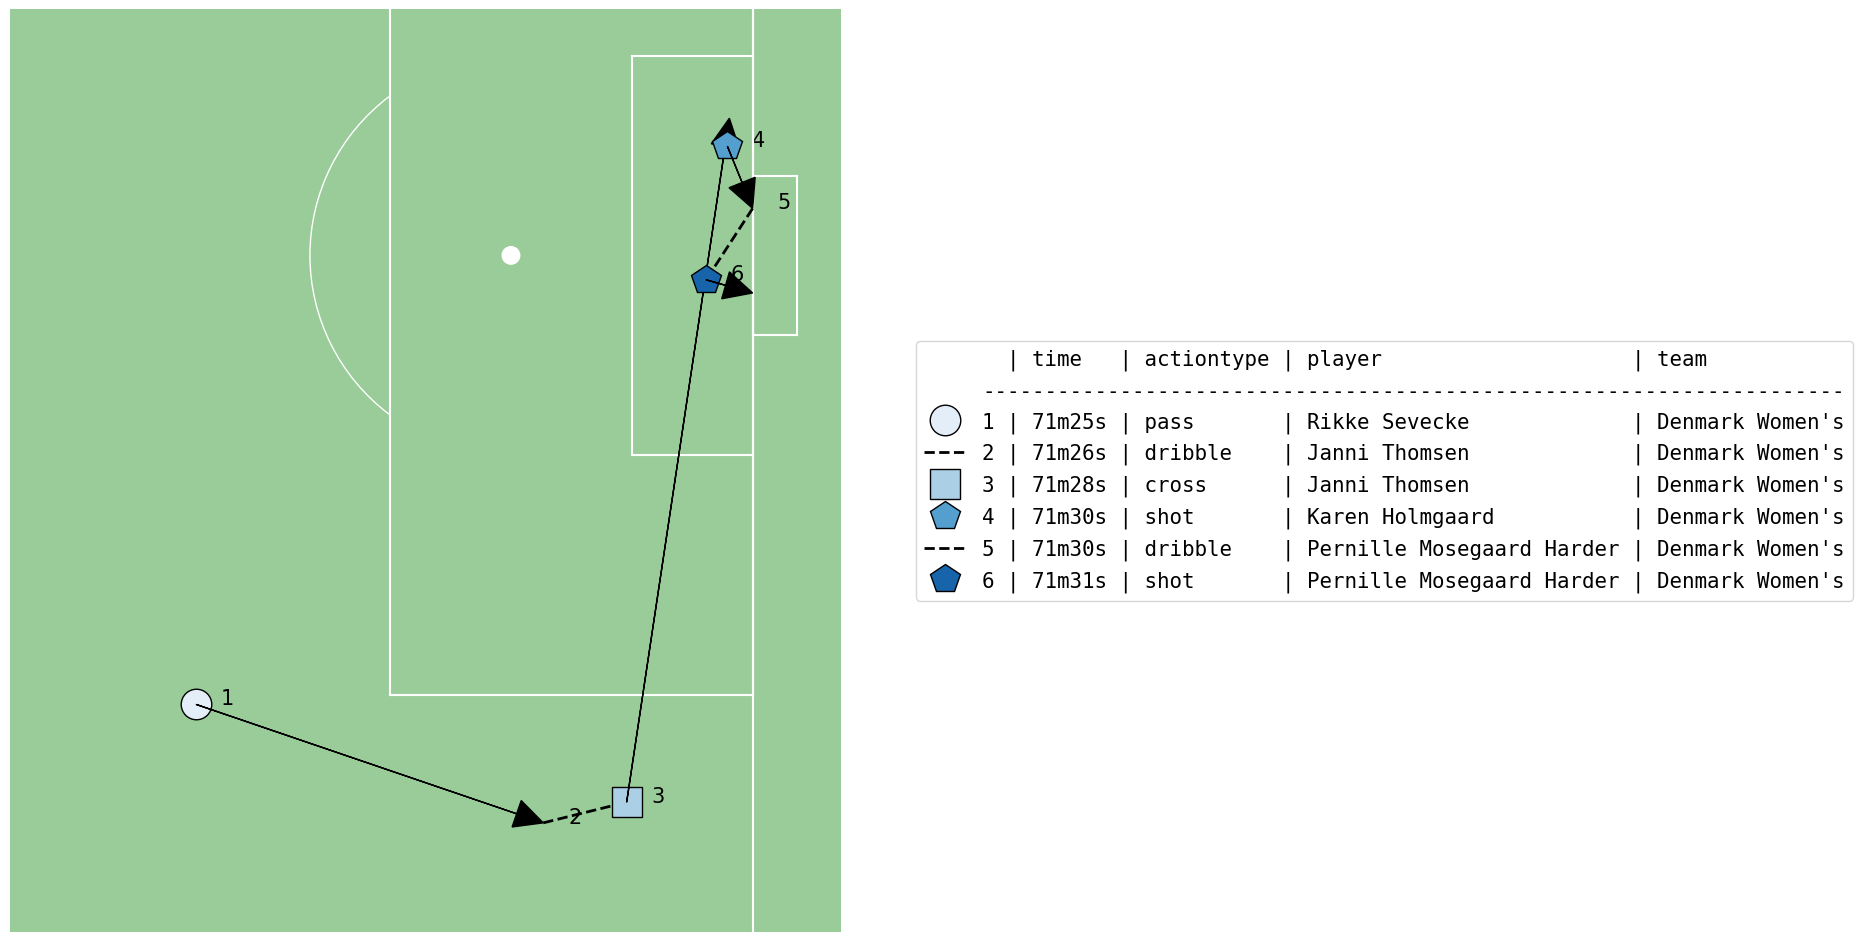

In [146]:
# Select the 5 actions preceding the 1-0
shot = 1742
a = actions[shot-5:shot+1].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = mps.actions(color="green",
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=True,
    figsize=11
)